Based on https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
!wget https://github.com/cchan/twitchgan/blob/master/dataset-first-50k.hdf5?raw=true -O dataset.hdf5

--2019-01-08 19:07:48--  https://github.com/cchan/twitchgan/blob/master/dataset-first-50k.hdf5?raw=true
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cchan/twitchgan/raw/master/dataset-first-50k.hdf5 [following]
--2019-01-08 19:07:48--  https://github.com/cchan/twitchgan/raw/master/dataset-first-50k.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cchan/twitchgan/master/dataset-first-50k.hdf5 [following]
--2019-01-08 19:07:48--  https://raw.githubusercontent.com/cchan/twitchgan/master/dataset-first-50k.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connecte

In [0]:
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [0]:
import torch
import torch.nn as nn

# https://github.com/pytorch/examples/blob/master/dcgan/main.py

image_shape = (4, 28, 28)
latent_shape = (100, 1, 1)

class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(-1, *self.shape)


# Generator
G = nn.Sequential(
        # ConvTranspose2d: next width or height := (prev_height - 1) * stride + kernel_size - padding * 2

        # https://distill.pub/2016/deconv-checkerboard/

        # Shape: 100 x 1 x 1
        nn.ConvTranspose2d(100, 128, kernel_size=7, stride=1, padding=0),
        nn.ReLU(True),
        nn.BatchNorm2d(128), # nn.utils.SpectralNorm(),
        # Shape: 128 x 7 x 7
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.BatchNorm2d(64), # nn.utils.SpectralNorm(),
        # Shape: 64 x 14 x 14
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(True),
        nn.BatchNorm2d(32), # nn.utils.SpectralNorm(),
        # Shape: 32 x 28 x 28
        nn.ConvTranspose2d(32, 4, kernel_size=5, stride=1, padding=2),
        nn.Tanh()
        # Shape: 4 x 28 x 28
)

# Discriminator
D = nn.Sequential(
        # Shape: 4 x 28 x 28
        nn.Conv2d(4, 32, kernel_size=5, stride=1, padding=2),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(32),
        #nn.Dropout(0.2),
        # Shape: 32 x 28 x 28
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(64),
        #nn.Dropout(0.2),
        # Shape: 64 x 14 x 14
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # => batch, 64, 14, 14
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(128),
        #nn.Dropout(0.2),
        # Shape: 128 x 7 x 7
        nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0), # => batch, 128, 7, 7
        nn.Sigmoid()
        # Shape: 100 x 1 x 1
)


# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def printthings(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print(self.__class__.__name__ + ': ', input[0].size(), "=>", output.data.size())

handles = [m.register_forward_hook(printthings) for m in D.modules()] \
        + [m.register_forward_hook(printthings) for m in G.modules()]
print("GENERATOR")
g_out = G(torch.randn(123, *latent_shape))
assert(g_out.size() == torch.randn(123, *image_shape).size())
print("DISCRIMINATOR")
d_out = D(g_out)
assert(d_out.size() == torch.randn(123, *((1,)*len(image_shape))).size())
for handle in handles:
    handle.remove()

# Device setting
D = D.to(device)
G = G.to(device)

GENERATOR
ConvTranspose2d:  torch.Size([123, 100, 1, 1]) => torch.Size([123, 128, 7, 7])
ReLU:  torch.Size([123, 128, 7, 7]) => torch.Size([123, 128, 7, 7])
BatchNorm2d:  torch.Size([123, 128, 7, 7]) => torch.Size([123, 128, 7, 7])
ConvTranspose2d:  torch.Size([123, 128, 7, 7]) => torch.Size([123, 64, 14, 14])
ReLU:  torch.Size([123, 64, 14, 14]) => torch.Size([123, 64, 14, 14])
BatchNorm2d:  torch.Size([123, 64, 14, 14]) => torch.Size([123, 64, 14, 14])
ConvTranspose2d:  torch.Size([123, 64, 14, 14]) => torch.Size([123, 32, 28, 28])
ReLU:  torch.Size([123, 32, 28, 28]) => torch.Size([123, 32, 28, 28])
BatchNorm2d:  torch.Size([123, 32, 28, 28]) => torch.Size([123, 32, 28, 28])
ConvTranspose2d:  torch.Size([123, 32, 28, 28]) => torch.Size([123, 4, 28, 28])
Tanh:  torch.Size([123, 4, 28, 28]) => torch.Size([123, 4, 28, 28])
Sequential:  torch.Size([123, 100, 1, 1]) => torch.Size([123, 4, 28, 28])
DISCRIMINATOR
Conv2d:  torch.Size([123, 4, 28, 28]) => torch.Size([123, 32, 28, 28])
LeakyR

In [0]:
import h5py
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np

fname = 'dataset.hdf5'
dname = 'twitch_emotes'
with h5py.File(fname, 'r') as f:
    dataset = f[dname]
    preloaded_data = torch.tensor(np.moveaxis(dataset[:50000], 3, 1)/128 - 1, dtype=torch.float).to(device)
    print(preloaded_data[100][3][10])
    print(preloaded_data.size())

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def tensor2plt(img):
    return denorm(img[[2,1,0,3],:,:].permute(1,2,0))


tensor([ 0.4688,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,
         0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,
         0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,  0.9922,
         0.9922,  0.9922,  0.8750, -0.5312], device='cuda:0')
torch.Size([50000, 4, 28, 28])


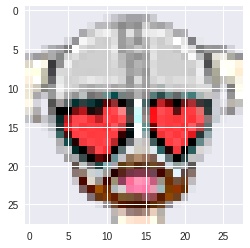

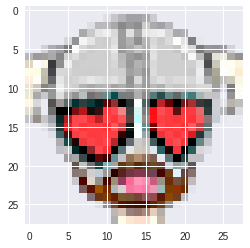

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

with h5py.File(fname, 'r') as f:
    dataset = f[dname]
    for image in dataset[:1]:
        plt.figure()
        plt.imshow(image[:,:,[2,1,0,3]])
        plt.show()

# Output first few real images
for image in preloaded_data[:1].cpu():
    plt.figure()
    plt.imshow(tensor2plt(image))
    plt.show()

Epoch [0/50], Step [1/10], d_loss: 1.6818, g_loss: 1.0536, D(x): 0.55, D(G(z)): 0.49
Epoch [0/50], Step [2/10], d_loss: 1.5828, g_loss: 1.1077, D(x): 0.60, D(G(z)): 0.49
Epoch [0/50], Step [3/10], d_loss: 1.3633, g_loss: 1.1774, D(x): 0.69, D(G(z)): 0.47
Epoch [0/50], Step [4/10], d_loss: 1.1537, g_loss: 1.2438, D(x): 0.78, D(G(z)): 0.46
Epoch [0/50], Step [5/10], d_loss: 0.9992, g_loss: 1.3283, D(x): 0.84, D(G(z)): 0.44
Epoch [0/50], Step [6/10], d_loss: 0.9009, g_loss: 1.4291, D(x): 0.88, D(G(z)): 0.42
Epoch [0/50], Step [7/10], d_loss: 0.8617, g_loss: 1.4523, D(x): 0.90, D(G(z)): 0.42
Epoch [0/50], Step [8/10], d_loss: 0.7794, g_loss: 1.5757, D(x): 0.92, D(G(z)): 0.40
Epoch [0/50], Step [9/10], d_loss: 0.7307, g_loss: 1.6383, D(x): 0.93, D(G(z)): 0.39
Epoch [0/50], Step [10/10], d_loss: 0.7055, g_loss: 1.6727, D(x): 0.94, D(G(z)): 0.38


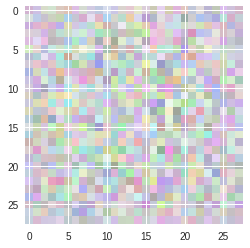

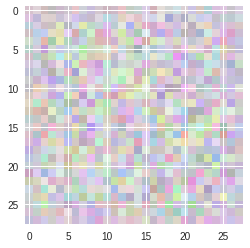

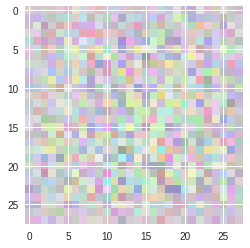

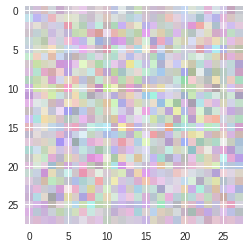

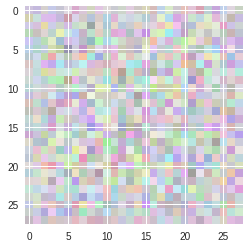

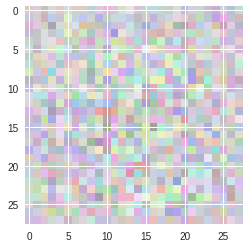

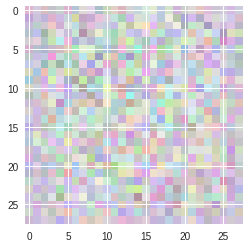

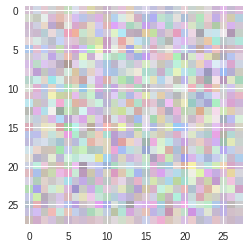

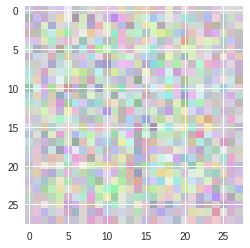

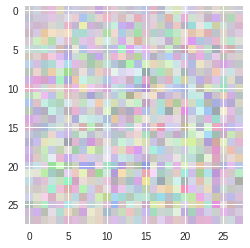

Epoch [1/50], Step [1/10], d_loss: 0.6521, g_loss: 1.7216, D(x): 0.97, D(G(z)): 0.38
Epoch [1/50], Step [2/10], d_loss: 0.6597, g_loss: 1.7615, D(x): 0.96, D(G(z)): 0.38
Epoch [1/50], Step [3/10], d_loss: 0.6421, g_loss: 1.8148, D(x): 0.96, D(G(z)): 0.37
Epoch [1/50], Step [4/10], d_loss: 0.6726, g_loss: 1.8175, D(x): 0.95, D(G(z)): 0.38
Epoch [1/50], Step [5/10], d_loss: 0.6691, g_loss: 1.8710, D(x): 0.95, D(G(z)): 0.38
Epoch [1/50], Step [6/10], d_loss: 0.7034, g_loss: 1.8980, D(x): 0.95, D(G(z)): 0.38
Epoch [1/50], Step [7/10], d_loss: 0.7303, g_loss: 1.9527, D(x): 0.93, D(G(z)): 0.38
Epoch [1/50], Step [8/10], d_loss: 0.7572, g_loss: 2.0024, D(x): 0.93, D(G(z)): 0.38
Epoch [1/50], Step [9/10], d_loss: 0.8200, g_loss: 2.0850, D(x): 0.90, D(G(z)): 0.38
Epoch [1/50], Step [10/10], d_loss: 0.8383, g_loss: 2.1606, D(x): 0.89, D(G(z)): 0.38


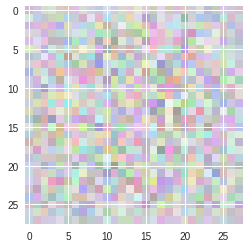

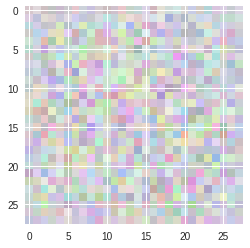

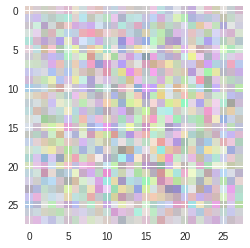

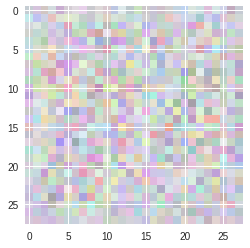

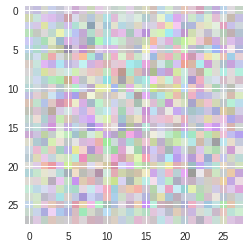

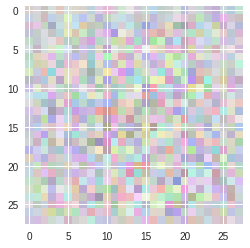

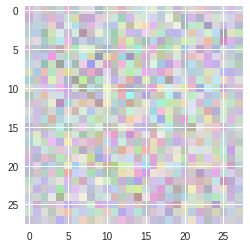

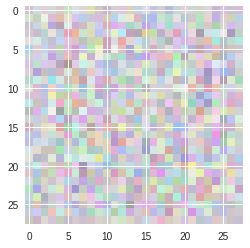

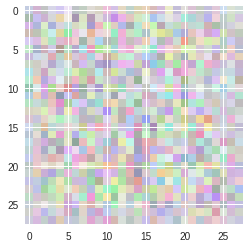

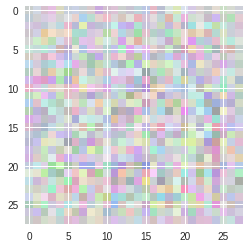

Epoch [2/50], Step [1/10], d_loss: 0.8038, g_loss: 2.2161, D(x): 0.92, D(G(z)): 0.39
Epoch [2/50], Step [2/10], d_loss: 0.9065, g_loss: 2.3967, D(x): 0.86, D(G(z)): 0.37
Epoch [2/50], Step [3/10], d_loss: 1.0443, g_loss: 2.4454, D(x): 0.81, D(G(z)): 0.36
Epoch [2/50], Step [4/10], d_loss: 1.1571, g_loss: 2.4980, D(x): 0.78, D(G(z)): 0.36
Epoch [2/50], Step [5/10], d_loss: 1.2326, g_loss: 2.4984, D(x): 0.75, D(G(z)): 0.36
Epoch [2/50], Step [6/10], d_loss: 1.2997, g_loss: 2.5082, D(x): 0.74, D(G(z)): 0.38
Epoch [2/50], Step [7/10], d_loss: 1.2233, g_loss: 2.6194, D(x): 0.77, D(G(z)): 0.39
Epoch [2/50], Step [8/10], d_loss: 0.9490, g_loss: 3.0994, D(x): 0.83, D(G(z)): 0.35
Epoch [2/50], Step [9/10], d_loss: 0.8343, g_loss: 3.7498, D(x): 0.82, D(G(z)): 0.27
Epoch [2/50], Step [10/10], d_loss: 0.5751, g_loss: 4.5304, D(x): 0.85, D(G(z)): 0.18


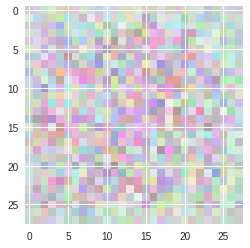

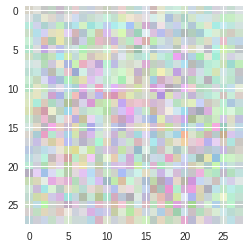

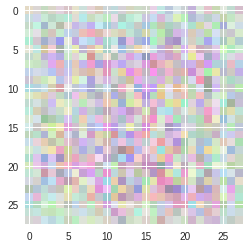

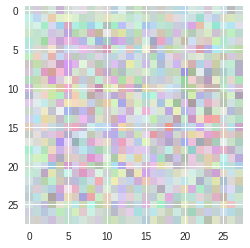

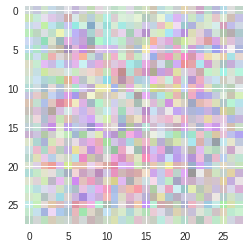

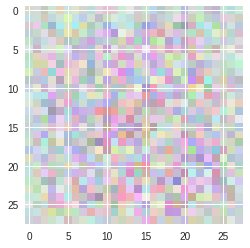

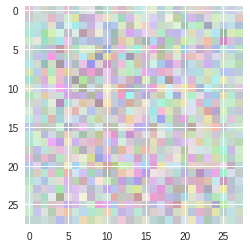

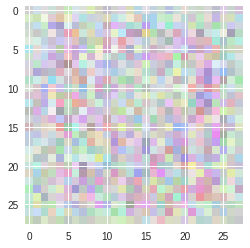

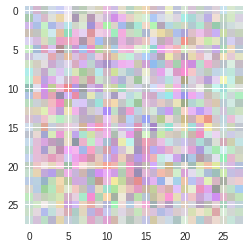

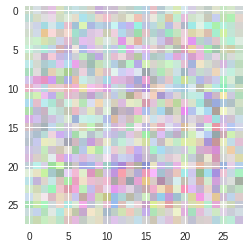

Epoch [3/50], Step [1/10], d_loss: 0.3677, g_loss: 5.1579, D(x): 0.90, D(G(z)): 0.12
Epoch [3/50], Step [2/10], d_loss: 0.2954, g_loss: 5.7688, D(x): 0.90, D(G(z)): 0.07
Epoch [3/50], Step [3/10], d_loss: 0.2551, g_loss: 6.0403, D(x): 0.92, D(G(z)): 0.05
Epoch [3/50], Step [4/10], d_loss: 0.2327, g_loss: 6.0770, D(x): 0.92, D(G(z)): 0.05
Epoch [3/50], Step [5/10], d_loss: 0.2386, g_loss: 5.8374, D(x): 0.92, D(G(z)): 0.06
Epoch [3/50], Step [6/10], d_loss: 0.2500, g_loss: 5.4001, D(x): 0.93, D(G(z)): 0.08
Epoch [3/50], Step [7/10], d_loss: 0.3033, g_loss: 4.8952, D(x): 0.93, D(G(z)): 0.11
Epoch [3/50], Step [8/10], d_loss: 0.3826, g_loss: 4.3982, D(x): 0.94, D(G(z)): 0.17
Epoch [3/50], Step [9/10], d_loss: 0.5670, g_loss: 4.0662, D(x): 0.93, D(G(z)): 0.24
Epoch [3/50], Step [10/10], d_loss: 0.6746, g_loss: 4.0571, D(x): 0.94, D(G(z)): 0.29


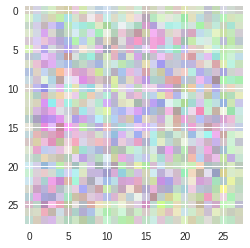

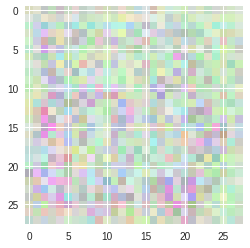

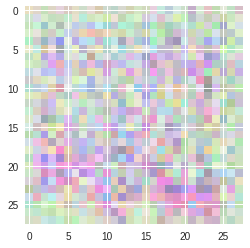

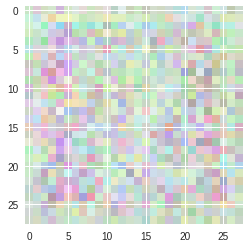

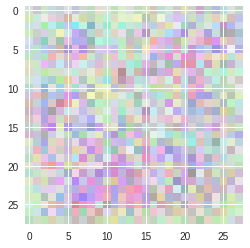

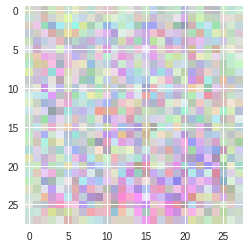

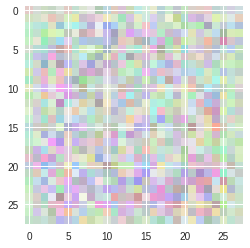

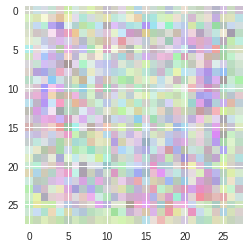

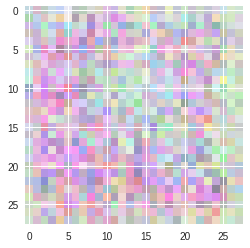

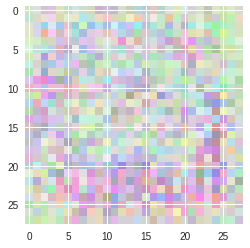

Epoch [4/50], Step [1/10], d_loss: 0.6305, g_loss: 4.2642, D(x): 0.96, D(G(z)): 0.30
Epoch [4/50], Step [2/10], d_loss: 0.5937, g_loss: 4.6538, D(x): 0.95, D(G(z)): 0.27
Epoch [4/50], Step [3/10], d_loss: 0.5323, g_loss: 4.9818, D(x): 0.95, D(G(z)): 0.23
Epoch [4/50], Step [4/10], d_loss: 0.4968, g_loss: 5.3067, D(x): 0.93, D(G(z)): 0.19
Epoch [4/50], Step [5/10], d_loss: 0.4972, g_loss: 5.5582, D(x): 0.92, D(G(z)): 0.15
Epoch [4/50], Step [6/10], d_loss: 0.4776, g_loss: 5.6267, D(x): 0.91, D(G(z)): 0.14
Epoch [4/50], Step [7/10], d_loss: 0.5458, g_loss: 5.5562, D(x): 0.89, D(G(z)): 0.14
Epoch [4/50], Step [8/10], d_loss: 0.5245, g_loss: 5.4076, D(x): 0.91, D(G(z)): 0.16
Epoch [4/50], Step [9/10], d_loss: 0.7446, g_loss: 5.0514, D(x): 0.89, D(G(z)): 0.20
Epoch [4/50], Step [10/10], d_loss: 0.8626, g_loss: 4.8243, D(x): 0.90, D(G(z)): 0.25


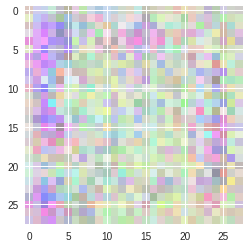

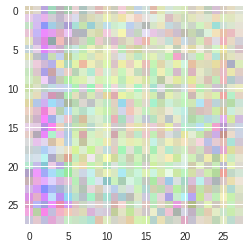

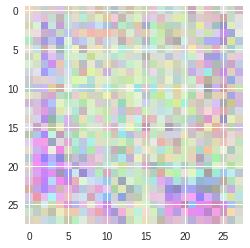

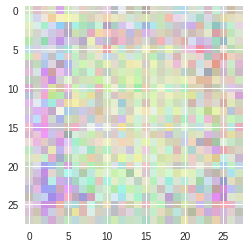

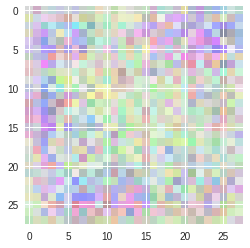

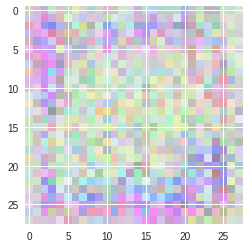

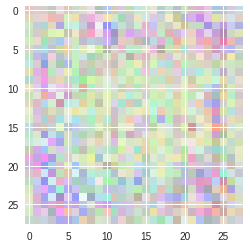

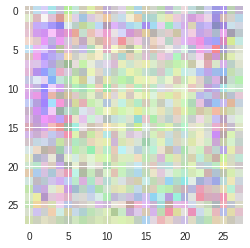

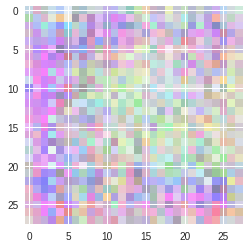

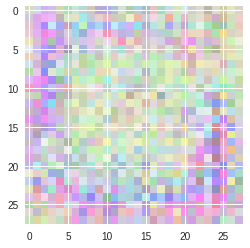

Epoch [5/50], Step [1/10], d_loss: 0.9173, g_loss: 4.5254, D(x): 0.94, D(G(z)): 0.30
Epoch [5/50], Step [2/10], d_loss: 1.1218, g_loss: 4.4276, D(x): 0.94, D(G(z)): 0.34
Epoch [5/50], Step [3/10], d_loss: 1.2210, g_loss: 4.4362, D(x): 0.94, D(G(z)): 0.37
Epoch [5/50], Step [4/10], d_loss: 1.2873, g_loss: 4.6121, D(x): 0.93, D(G(z)): 0.37
Epoch [5/50], Step [5/10], d_loss: 1.0993, g_loss: 5.0490, D(x): 0.93, D(G(z)): 0.33
Epoch [5/50], Step [6/10], d_loss: 0.8558, g_loss: 5.6978, D(x): 0.92, D(G(z)): 0.27
Epoch [5/50], Step [7/10], d_loss: 0.6862, g_loss: 6.2671, D(x): 0.91, D(G(z)): 0.21
Epoch [5/50], Step [8/10], d_loss: 0.4040, g_loss: 6.8421, D(x): 0.93, D(G(z)): 0.13
Epoch [5/50], Step [9/10], d_loss: 0.4226, g_loss: 7.2202, D(x): 0.90, D(G(z)): 0.09
Epoch [5/50], Step [10/10], d_loss: 0.3386, g_loss: 7.2784, D(x): 0.91, D(G(z)): 0.07


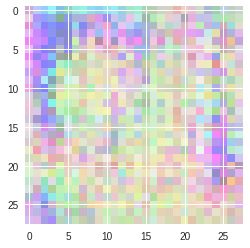

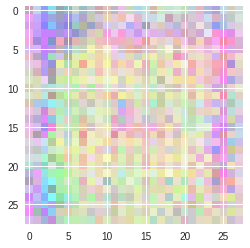

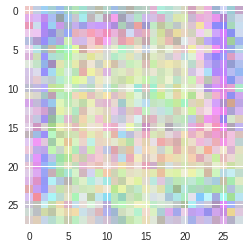

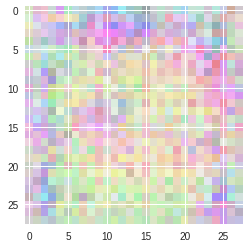

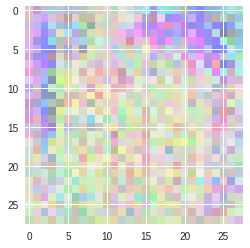

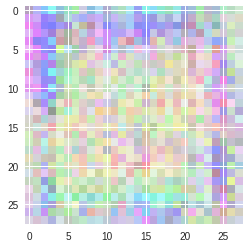

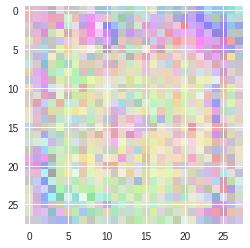

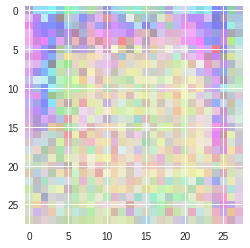

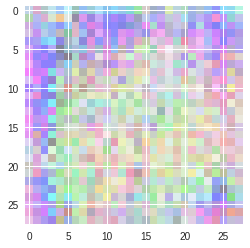

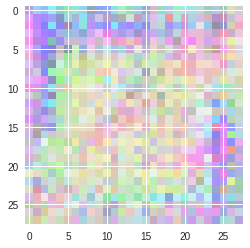

Epoch [6/50], Step [1/10], d_loss: 0.3237, g_loss: 7.0338, D(x): 0.92, D(G(z)): 0.08
Epoch [6/50], Step [2/10], d_loss: 0.3977, g_loss: 6.4270, D(x): 0.91, D(G(z)): 0.11
Epoch [6/50], Step [3/10], d_loss: 0.5526, g_loss: 5.7313, D(x): 0.91, D(G(z)): 0.17
Epoch [6/50], Step [4/10], d_loss: 0.7878, g_loss: 5.0928, D(x): 0.92, D(G(z)): 0.27
Epoch [6/50], Step [5/10], d_loss: 1.1622, g_loss: 4.7001, D(x): 0.91, D(G(z)): 0.37
Epoch [6/50], Step [6/10], d_loss: 1.5599, g_loss: 4.5793, D(x): 0.90, D(G(z)): 0.47
Epoch [6/50], Step [7/10], d_loss: 1.7922, g_loss: 4.7865, D(x): 0.89, D(G(z)): 0.51
Epoch [6/50], Step [8/10], d_loss: 1.7120, g_loss: 5.3726, D(x): 0.91, D(G(z)): 0.49
Epoch [6/50], Step [9/10], d_loss: 1.5876, g_loss: 6.1045, D(x): 0.87, D(G(z)): 0.44
Epoch [6/50], Step [10/10], d_loss: 1.2125, g_loss: 6.9326, D(x): 0.87, D(G(z)): 0.35


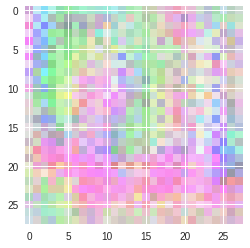

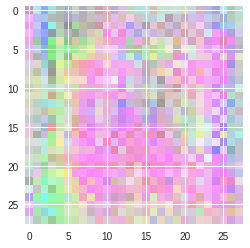

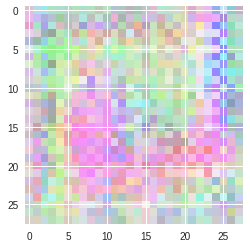

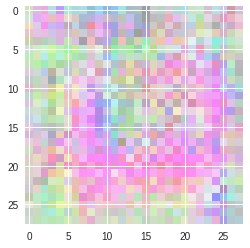

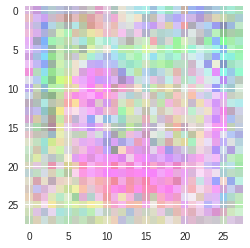

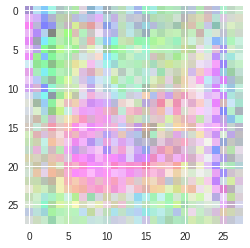

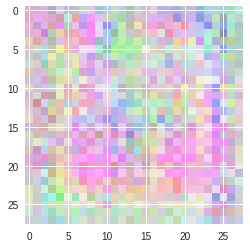

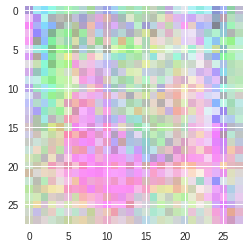

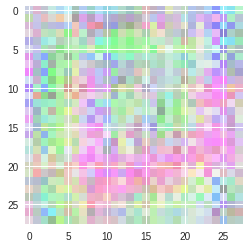

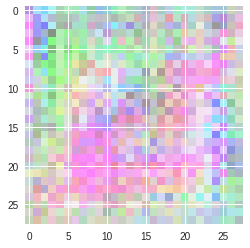

Epoch [7/50], Step [1/10], d_loss: 0.9410, g_loss: 7.5426, D(x): 0.87, D(G(z)): 0.28
Epoch [7/50], Step [2/10], d_loss: 0.8476, g_loss: 7.9562, D(x): 0.84, D(G(z)): 0.21
Epoch [7/50], Step [3/10], d_loss: 0.8072, g_loss: 8.0976, D(x): 0.82, D(G(z)): 0.17
Epoch [7/50], Step [4/10], d_loss: 0.7773, g_loss: 7.9070, D(x): 0.82, D(G(z)): 0.15
Epoch [7/50], Step [5/10], d_loss: 0.8122, g_loss: 7.5672, D(x): 0.81, D(G(z)): 0.15
Epoch [7/50], Step [6/10], d_loss: 0.7771, g_loss: 7.1797, D(x): 0.82, D(G(z)): 0.17
Epoch [7/50], Step [7/10], d_loss: 0.8693, g_loss: 6.9041, D(x): 0.81, D(G(z)): 0.19
Epoch [7/50], Step [8/10], d_loss: 0.8823, g_loss: 6.6885, D(x): 0.85, D(G(z)): 0.22
Epoch [7/50], Step [9/10], d_loss: 0.8774, g_loss: 6.7260, D(x): 0.85, D(G(z)): 0.23
Epoch [7/50], Step [10/10], d_loss: 0.8566, g_loss: 6.9167, D(x): 0.86, D(G(z)): 0.23


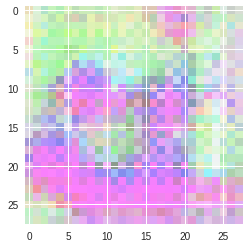

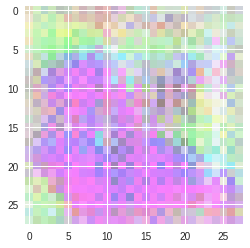

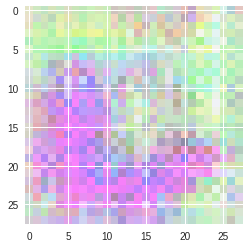

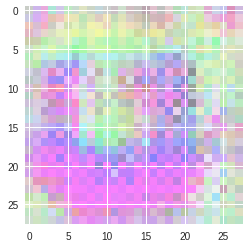

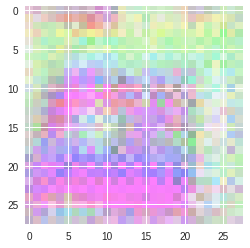

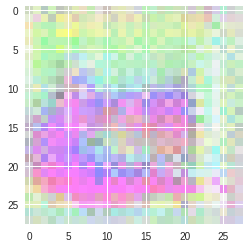

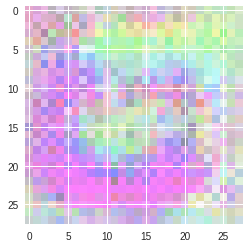

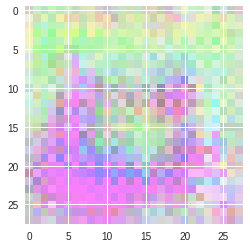

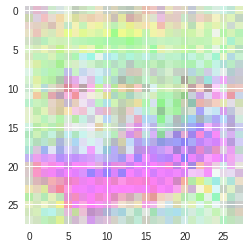

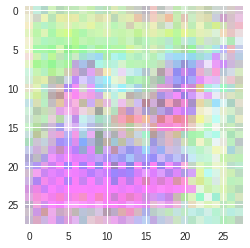

Epoch [8/50], Step [1/10], d_loss: 0.5844, g_loss: 7.1605, D(x): 0.93, D(G(z)): 0.22
Epoch [8/50], Step [2/10], d_loss: 0.6142, g_loss: 7.4193, D(x): 0.91, D(G(z)): 0.20
Epoch [8/50], Step [3/10], d_loss: 0.5668, g_loss: 7.7604, D(x): 0.90, D(G(z)): 0.16
Epoch [8/50], Step [4/10], d_loss: 0.5156, g_loss: 7.9225, D(x): 0.90, D(G(z)): 0.13
Epoch [8/50], Step [5/10], d_loss: 0.5172, g_loss: 7.8665, D(x): 0.89, D(G(z)): 0.12
Epoch [8/50], Step [6/10], d_loss: 0.4908, g_loss: 7.6944, D(x): 0.89, D(G(z)): 0.11
Epoch [8/50], Step [7/10], d_loss: 0.5986, g_loss: 7.2546, D(x): 0.88, D(G(z)): 0.13
Epoch [8/50], Step [8/10], d_loss: 0.5722, g_loss: 6.9180, D(x): 0.90, D(G(z)): 0.14
Epoch [8/50], Step [9/10], d_loss: 0.6498, g_loss: 6.5681, D(x): 0.88, D(G(z)): 0.18
Epoch [8/50], Step [10/10], d_loss: 0.7358, g_loss: 6.4090, D(x): 0.88, D(G(z)): 0.21


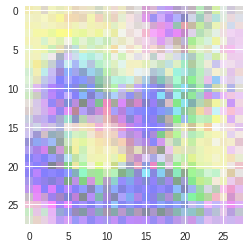

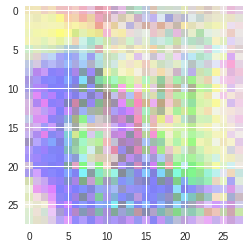

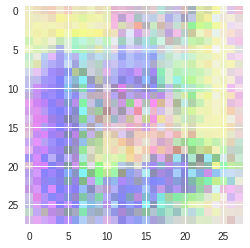

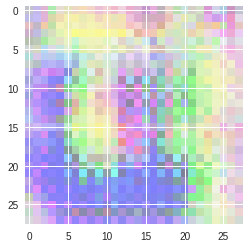

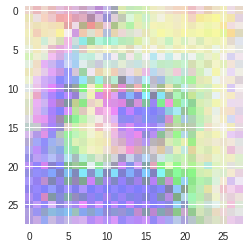

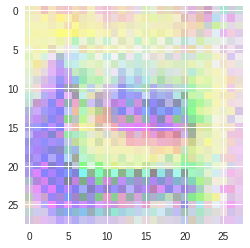

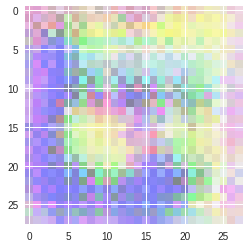

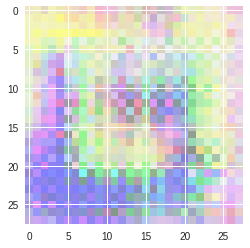

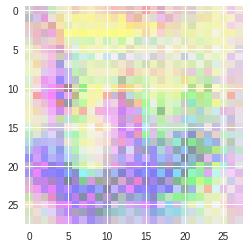

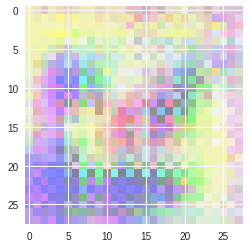

Epoch [9/50], Step [1/10], d_loss: 0.5331, g_loss: 6.5811, D(x): 0.94, D(G(z)): 0.20
Epoch [9/50], Step [2/10], d_loss: 0.5582, g_loss: 6.8453, D(x): 0.93, D(G(z)): 0.19
Epoch [9/50], Step [3/10], d_loss: 0.5344, g_loss: 7.1911, D(x): 0.92, D(G(z)): 0.16
Epoch [9/50], Step [4/10], d_loss: 0.4743, g_loss: 7.4530, D(x): 0.92, D(G(z)): 0.13
Epoch [9/50], Step [5/10], d_loss: 0.4495, g_loss: 7.5296, D(x): 0.91, D(G(z)): 0.11
Epoch [9/50], Step [6/10], d_loss: 0.4333, g_loss: 7.4852, D(x): 0.91, D(G(z)): 0.10
Epoch [9/50], Step [7/10], d_loss: 0.4539, g_loss: 7.2654, D(x): 0.91, D(G(z)): 0.10
Epoch [9/50], Step [8/10], d_loss: 0.4297, g_loss: 7.0881, D(x): 0.93, D(G(z)): 0.11
Epoch [9/50], Step [9/10], d_loss: 0.4797, g_loss: 6.8860, D(x): 0.92, D(G(z)): 0.13
Epoch [9/50], Step [10/10], d_loss: 0.4979, g_loss: 6.7705, D(x): 0.92, D(G(z)): 0.14


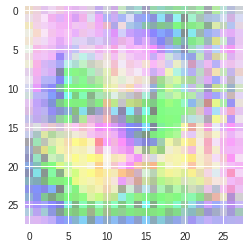

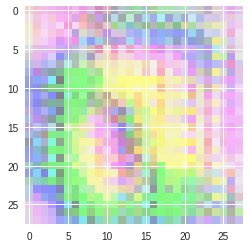

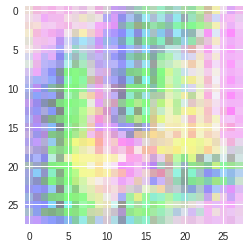

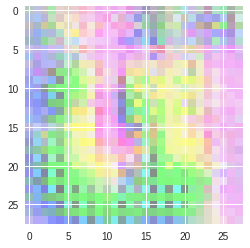

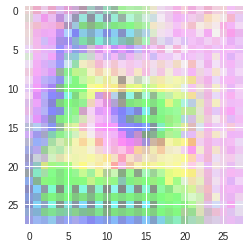

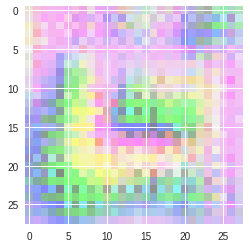

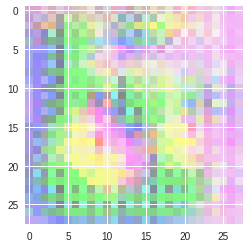

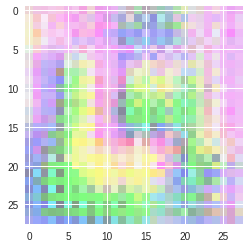

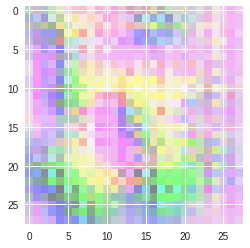

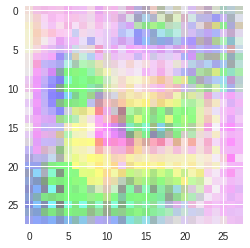

Epoch [10/50], Step [1/10], d_loss: 0.3835, g_loss: 6.8516, D(x): 0.96, D(G(z)): 0.14
Epoch [10/50], Step [2/10], d_loss: 0.3925, g_loss: 7.0383, D(x): 0.95, D(G(z)): 0.13
Epoch [10/50], Step [3/10], d_loss: 0.4129, g_loss: 7.1364, D(x): 0.94, D(G(z)): 0.12
Epoch [10/50], Step [4/10], d_loss: 0.3892, g_loss: 7.2506, D(x): 0.94, D(G(z)): 0.12
Epoch [10/50], Step [5/10], d_loss: 0.3969, g_loss: 7.2486, D(x): 0.94, D(G(z)): 0.12
Epoch [10/50], Step [6/10], d_loss: 0.3796, g_loss: 7.2312, D(x): 0.95, D(G(z)): 0.12
Epoch [10/50], Step [7/10], d_loss: 0.3943, g_loss: 7.1835, D(x): 0.94, D(G(z)): 0.12
Epoch [10/50], Step [8/10], d_loss: 0.3873, g_loss: 6.9686, D(x): 0.96, D(G(z)): 0.14
Epoch [10/50], Step [9/10], d_loss: 0.4442, g_loss: 6.7556, D(x): 0.95, D(G(z)): 0.16
Epoch [10/50], Step [10/10], d_loss: 0.4724, g_loss: 6.6389, D(x): 0.95, D(G(z)): 0.17


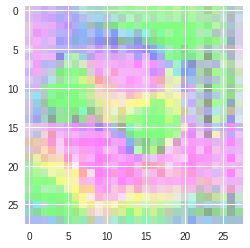

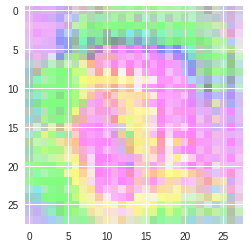

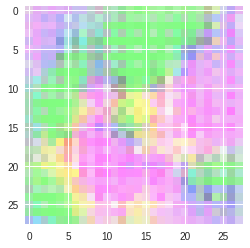

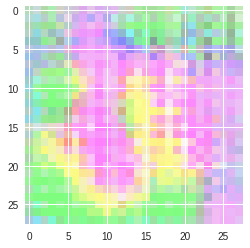

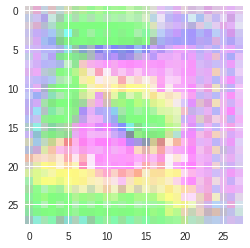

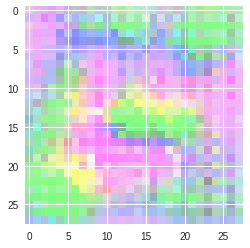

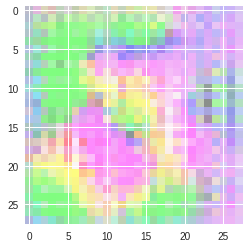

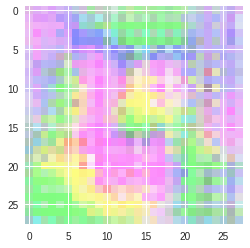

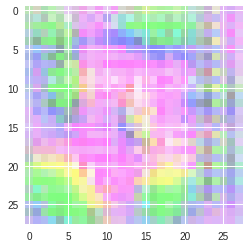

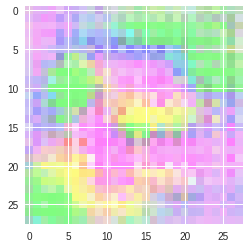

Epoch [11/50], Step [1/10], d_loss: 0.4594, g_loss: 6.5855, D(x): 0.97, D(G(z)): 0.18
Epoch [11/50], Step [2/10], d_loss: 0.4561, g_loss: 6.7125, D(x): 0.96, D(G(z)): 0.18
Epoch [11/50], Step [3/10], d_loss: 0.4375, g_loss: 6.9972, D(x): 0.95, D(G(z)): 0.16
Epoch [11/50], Step [4/10], d_loss: 0.3956, g_loss: 7.3253, D(x): 0.95, D(G(z)): 0.13
Epoch [11/50], Step [5/10], d_loss: 0.3291, g_loss: 7.6904, D(x): 0.94, D(G(z)): 0.10
Epoch [11/50], Step [6/10], d_loss: 0.2896, g_loss: 8.0307, D(x): 0.94, D(G(z)): 0.08
Epoch [11/50], Step [7/10], d_loss: 0.2964, g_loss: 8.4070, D(x): 0.92, D(G(z)): 0.06
Epoch [11/50], Step [8/10], d_loss: 0.2289, g_loss: 8.6182, D(x): 0.93, D(G(z)): 0.04
Epoch [11/50], Step [9/10], d_loss: 0.2780, g_loss: 8.7259, D(x): 0.92, D(G(z)): 0.04
Epoch [11/50], Step [10/10], d_loss: 0.2870, g_loss: 8.6915, D(x): 0.91, D(G(z)): 0.03


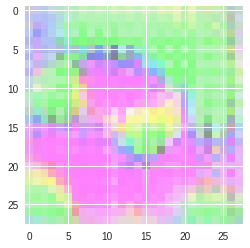

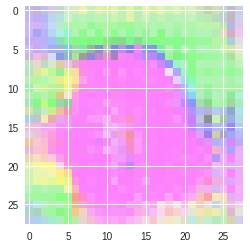

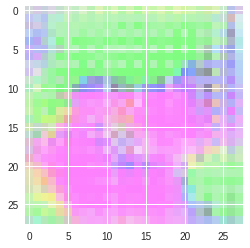

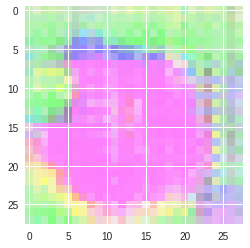

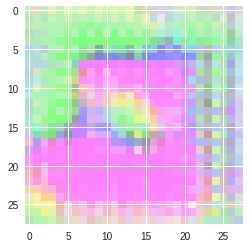

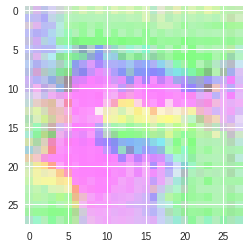

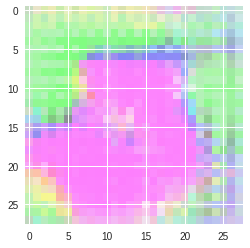

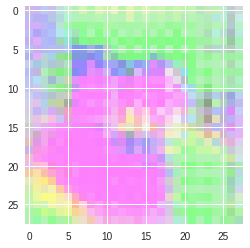

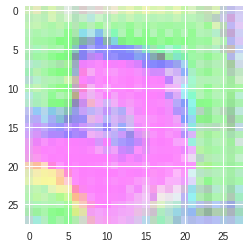

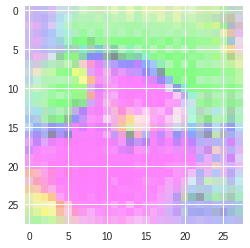

Epoch [12/50], Step [1/10], d_loss: 0.1813, g_loss: 8.5791, D(x): 0.95, D(G(z)): 0.04
Epoch [12/50], Step [2/10], d_loss: 0.1891, g_loss: 8.5975, D(x): 0.94, D(G(z)): 0.04
Epoch [12/50], Step [3/10], d_loss: 0.2285, g_loss: 8.6182, D(x): 0.93, D(G(z)): 0.04
Epoch [12/50], Step [4/10], d_loss: 0.2318, g_loss: 8.6805, D(x): 0.93, D(G(z)): 0.03
Epoch [12/50], Step [5/10], d_loss: 0.1985, g_loss: 8.8235, D(x): 0.93, D(G(z)): 0.03
Epoch [12/50], Step [6/10], d_loss: 0.1905, g_loss: 8.7481, D(x): 0.94, D(G(z)): 0.02
Epoch [12/50], Step [7/10], d_loss: 0.1976, g_loss: 8.7554, D(x): 0.93, D(G(z)): 0.02
Epoch [12/50], Step [8/10], d_loss: 0.1310, g_loss: 8.7158, D(x): 0.95, D(G(z)): 0.02
Epoch [12/50], Step [9/10], d_loss: 0.1716, g_loss: 8.6531, D(x): 0.94, D(G(z)): 0.02
Epoch [12/50], Step [10/10], d_loss: 0.1803, g_loss: 8.5437, D(x): 0.94, D(G(z)): 0.02


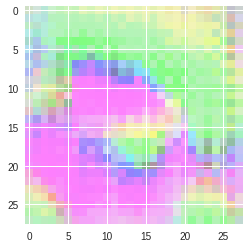

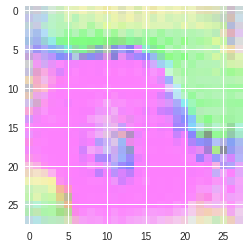

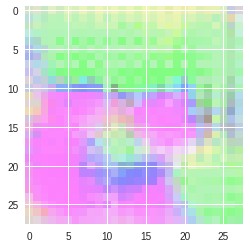

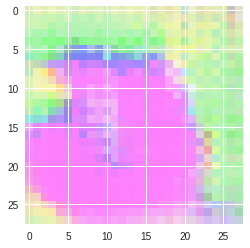

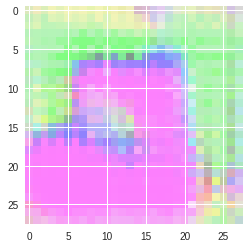

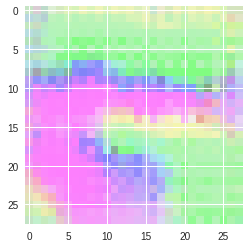

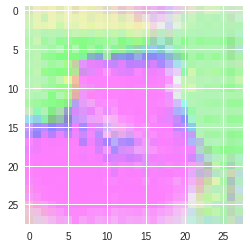

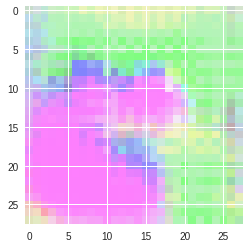

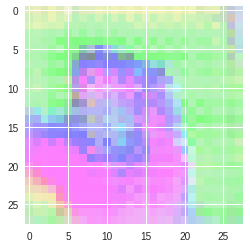

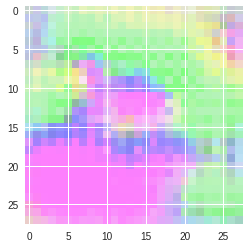

Epoch [13/50], Step [1/10], d_loss: 0.0952, g_loss: 8.3818, D(x): 0.98, D(G(z)): 0.03
Epoch [13/50], Step [2/10], d_loss: 0.1022, g_loss: 8.3095, D(x): 0.97, D(G(z)): 0.03
Epoch [13/50], Step [3/10], d_loss: 0.1267, g_loss: 8.1786, D(x): 0.97, D(G(z)): 0.03
Epoch [13/50], Step [4/10], d_loss: 0.1404, g_loss: 8.0584, D(x): 0.97, D(G(z)): 0.03
Epoch [13/50], Step [5/10], d_loss: 0.1268, g_loss: 7.9715, D(x): 0.97, D(G(z)): 0.04
Epoch [13/50], Step [6/10], d_loss: 0.1680, g_loss: 7.7788, D(x): 0.97, D(G(z)): 0.05
Epoch [13/50], Step [7/10], d_loss: 0.1797, g_loss: 7.8532, D(x): 0.97, D(G(z)): 0.05
Epoch [13/50], Step [8/10], d_loss: 0.1484, g_loss: 7.9129, D(x): 0.98, D(G(z)): 0.05
Epoch [13/50], Step [9/10], d_loss: 0.1972, g_loss: 7.9708, D(x): 0.97, D(G(z)): 0.06
Epoch [13/50], Step [10/10], d_loss: 0.1849, g_loss: 8.1387, D(x): 0.97, D(G(z)): 0.05


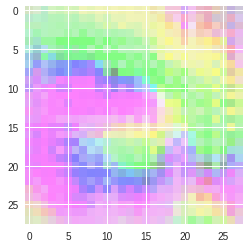

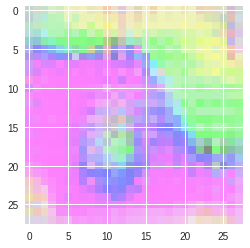

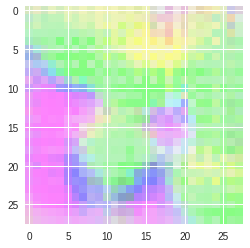

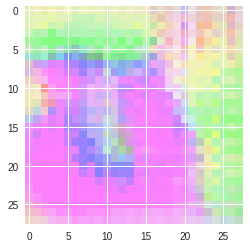

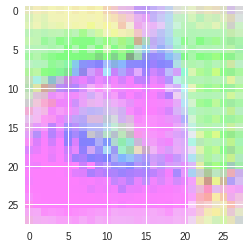

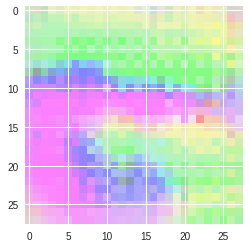

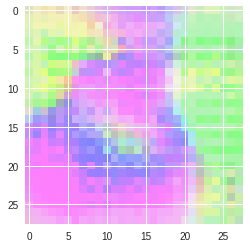

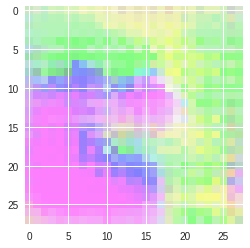

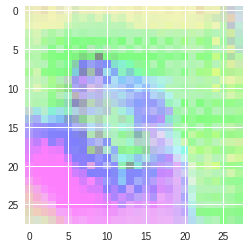

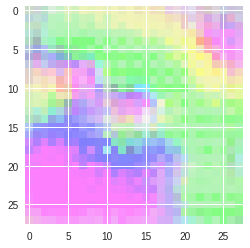

Epoch [14/50], Step [1/10], d_loss: 0.1299, g_loss: 8.2336, D(x): 0.99, D(G(z)): 0.05
Epoch [14/50], Step [2/10], d_loss: 0.1321, g_loss: 8.3003, D(x): 0.98, D(G(z)): 0.05
Epoch [14/50], Step [3/10], d_loss: 0.1154, g_loss: 8.4995, D(x): 0.98, D(G(z)): 0.04
Epoch [14/50], Step [4/10], d_loss: 0.1220, g_loss: 8.6368, D(x): 0.98, D(G(z)): 0.03
Epoch [14/50], Step [5/10], d_loss: 0.0975, g_loss: 8.6684, D(x): 0.98, D(G(z)): 0.03
Epoch [14/50], Step [6/10], d_loss: 0.1095, g_loss: 8.5043, D(x): 0.98, D(G(z)): 0.03
Epoch [14/50], Step [7/10], d_loss: 0.1168, g_loss: 8.5398, D(x): 0.97, D(G(z)): 0.03
Epoch [14/50], Step [8/10], d_loss: 0.0748, g_loss: 8.4424, D(x): 0.98, D(G(z)): 0.03
Epoch [14/50], Step [9/10], d_loss: 0.1212, g_loss: 8.2912, D(x): 0.97, D(G(z)): 0.03
Epoch [14/50], Step [10/10], d_loss: 0.1336, g_loss: 8.0965, D(x): 0.97, D(G(z)): 0.03


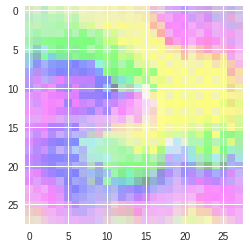

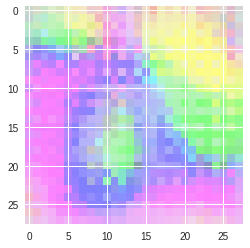

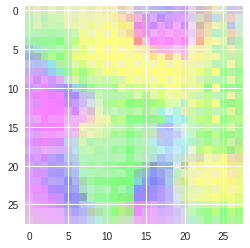

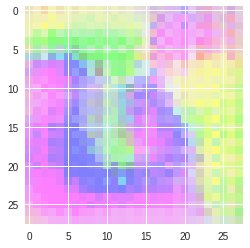

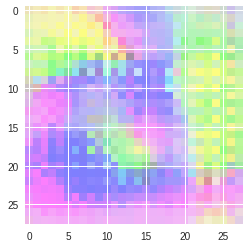

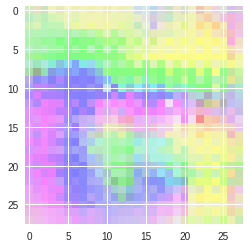

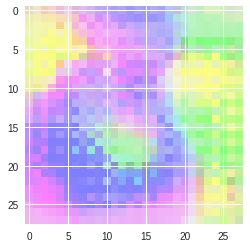

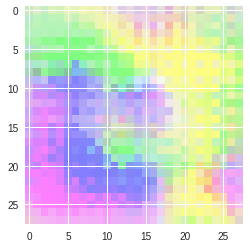

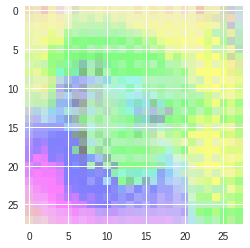

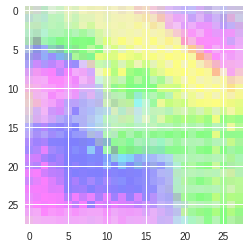

Epoch [15/50], Step [1/10], d_loss: 0.0975, g_loss: 7.8463, D(x): 0.99, D(G(z)): 0.04
Epoch [15/50], Step [2/10], d_loss: 0.1228, g_loss: 7.6522, D(x): 0.99, D(G(z)): 0.05
Epoch [15/50], Step [3/10], d_loss: 0.1204, g_loss: 7.7302, D(x): 0.98, D(G(z)): 0.04
Epoch [15/50], Step [4/10], d_loss: 0.1505, g_loss: 7.5896, D(x): 0.98, D(G(z)): 0.05
Epoch [15/50], Step [5/10], d_loss: 0.1512, g_loss: 7.6157, D(x): 0.98, D(G(z)): 0.06
Epoch [15/50], Step [6/10], d_loss: 0.1633, g_loss: 7.7710, D(x): 0.98, D(G(z)): 0.06
Epoch [15/50], Step [7/10], d_loss: 0.1811, g_loss: 7.7950, D(x): 0.98, D(G(z)): 0.06
Epoch [15/50], Step [8/10], d_loss: 0.1424, g_loss: 8.0683, D(x): 0.99, D(G(z)): 0.06
Epoch [15/50], Step [9/10], d_loss: 0.1573, g_loss: 8.3075, D(x): 0.98, D(G(z)): 0.05
Epoch [15/50], Step [10/10], d_loss: 0.1488, g_loss: 8.5777, D(x): 0.98, D(G(z)): 0.04


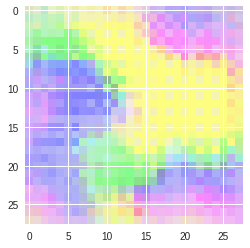

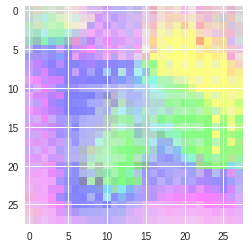

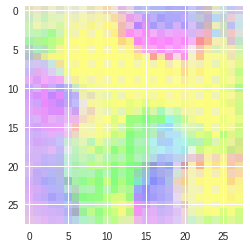

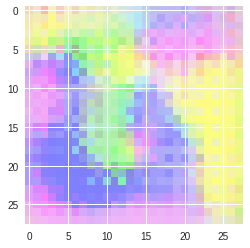

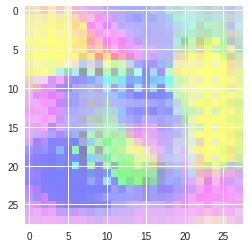

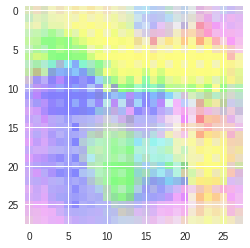

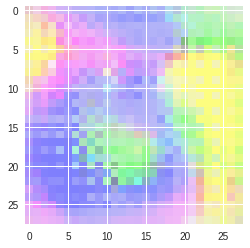

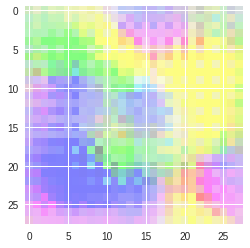

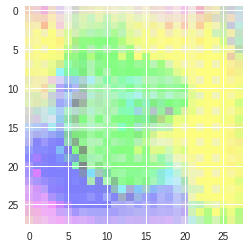

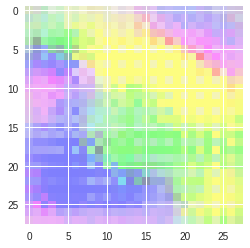

Epoch [16/50], Step [1/10], d_loss: 0.0951, g_loss: 8.6977, D(x): 0.99, D(G(z)): 0.04
Epoch [16/50], Step [2/10], d_loss: 0.1024, g_loss: 8.8704, D(x): 0.99, D(G(z)): 0.03
Epoch [16/50], Step [3/10], d_loss: 0.1018, g_loss: 8.9368, D(x): 0.98, D(G(z)): 0.03
Epoch [16/50], Step [4/10], d_loss: 0.1018, g_loss: 9.0256, D(x): 0.98, D(G(z)): 0.03
Epoch [16/50], Step [5/10], d_loss: 0.0943, g_loss: 9.0413, D(x): 0.98, D(G(z)): 0.03
Epoch [16/50], Step [6/10], d_loss: 0.1067, g_loss: 9.0022, D(x): 0.98, D(G(z)): 0.03
Epoch [16/50], Step [7/10], d_loss: 0.1220, g_loss: 8.8435, D(x): 0.98, D(G(z)): 0.03
Epoch [16/50], Step [8/10], d_loss: 0.0946, g_loss: 8.7330, D(x): 0.98, D(G(z)): 0.03
Epoch [16/50], Step [9/10], d_loss: 0.1258, g_loss: 8.5721, D(x): 0.98, D(G(z)): 0.04
Epoch [16/50], Step [10/10], d_loss: 0.1363, g_loss: 8.3737, D(x): 0.98, D(G(z)): 0.04


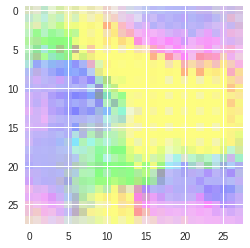

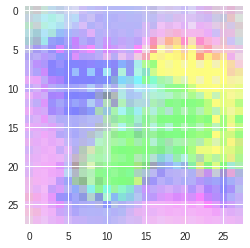

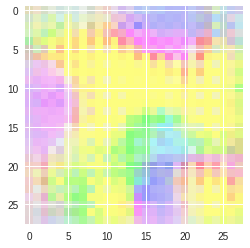

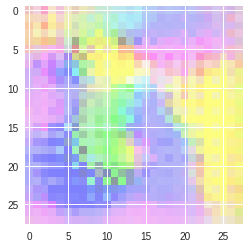

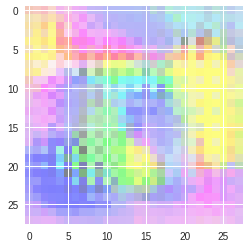

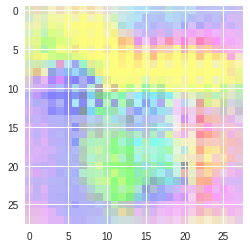

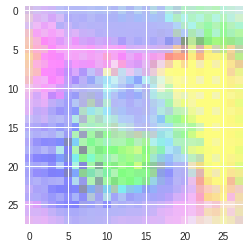

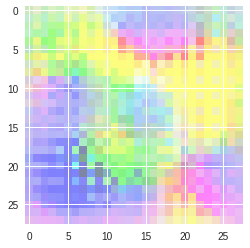

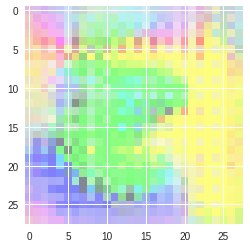

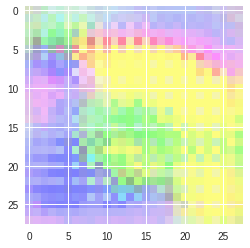

Epoch [17/50], Step [1/10], d_loss: 0.1106, g_loss: 8.0977, D(x): 0.99, D(G(z)): 0.05
Epoch [17/50], Step [2/10], d_loss: 0.1369, g_loss: 8.0447, D(x): 0.99, D(G(z)): 0.05
Epoch [17/50], Step [3/10], d_loss: 0.1363, g_loss: 7.8230, D(x): 0.98, D(G(z)): 0.05
Epoch [17/50], Step [4/10], d_loss: 0.1488, g_loss: 7.7181, D(x): 0.98, D(G(z)): 0.05
Epoch [17/50], Step [5/10], d_loss: 0.1437, g_loss: 7.5138, D(x): 0.98, D(G(z)): 0.05
Epoch [17/50], Step [6/10], d_loss: 0.1332, g_loss: 7.4408, D(x): 0.98, D(G(z)): 0.05
Epoch [17/50], Step [7/10], d_loss: 0.1573, g_loss: 7.3914, D(x): 0.97, D(G(z)): 0.05
Epoch [17/50], Step [8/10], d_loss: 0.1244, g_loss: 7.3800, D(x): 0.98, D(G(z)): 0.05
Epoch [17/50], Step [9/10], d_loss: 0.1418, g_loss: 7.2614, D(x): 0.98, D(G(z)): 0.05
Epoch [17/50], Step [10/10], d_loss: 0.1516, g_loss: 7.2887, D(x): 0.97, D(G(z)): 0.05


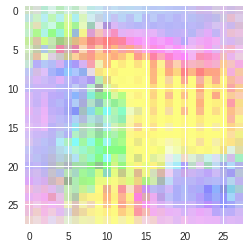

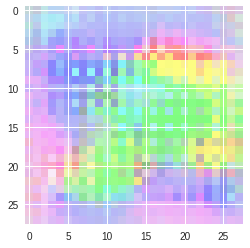

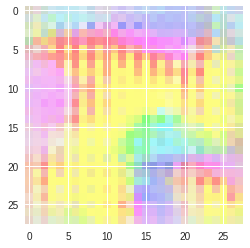

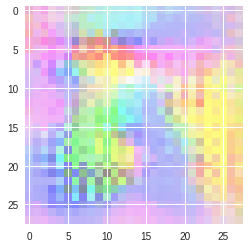

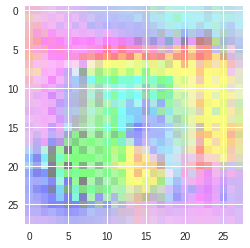

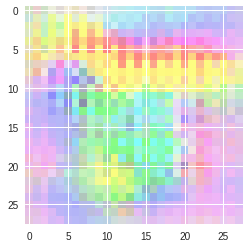

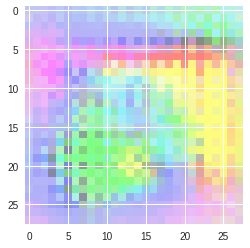

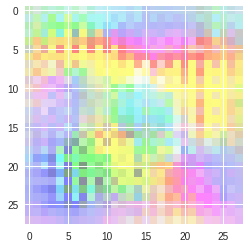

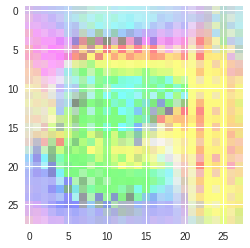

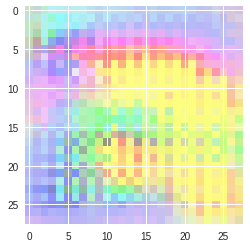

Epoch [18/50], Step [1/10], d_loss: 0.1015, g_loss: 7.2825, D(x): 0.99, D(G(z)): 0.05
Epoch [18/50], Step [2/10], d_loss: 0.1221, g_loss: 7.3742, D(x): 0.98, D(G(z)): 0.05
Epoch [18/50], Step [3/10], d_loss: 0.1154, g_loss: 7.4497, D(x): 0.98, D(G(z)): 0.05
Epoch [18/50], Step [4/10], d_loss: 0.1292, g_loss: 7.5391, D(x): 0.97, D(G(z)): 0.04
Epoch [18/50], Step [5/10], d_loss: 0.1208, g_loss: 7.5480, D(x): 0.97, D(G(z)): 0.04
Epoch [18/50], Step [6/10], d_loss: 0.1284, g_loss: 7.5552, D(x): 0.97, D(G(z)): 0.04
Epoch [18/50], Step [7/10], d_loss: 0.1520, g_loss: 7.4123, D(x): 0.97, D(G(z)): 0.04
Epoch [18/50], Step [8/10], d_loss: 0.1329, g_loss: 7.4679, D(x): 0.97, D(G(z)): 0.05
Epoch [18/50], Step [9/10], d_loss: 0.1393, g_loss: 7.3788, D(x): 0.97, D(G(z)): 0.05
Epoch [18/50], Step [10/10], d_loss: 0.1640, g_loss: 7.2963, D(x): 0.96, D(G(z)): 0.05


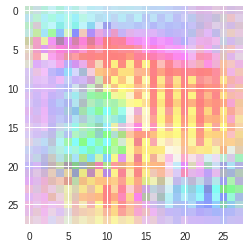

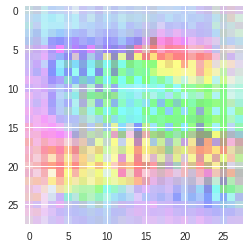

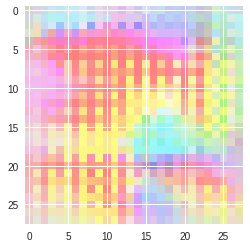

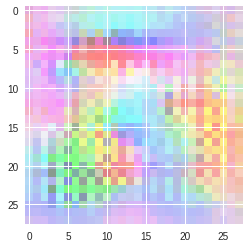

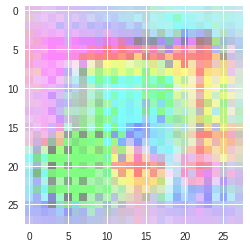

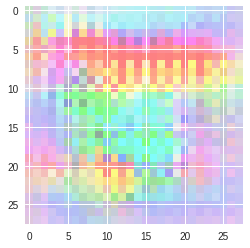

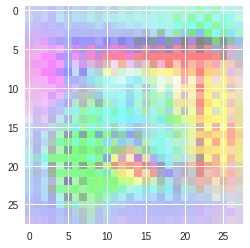

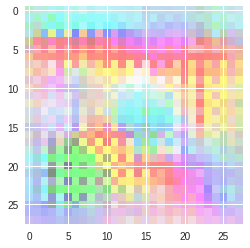

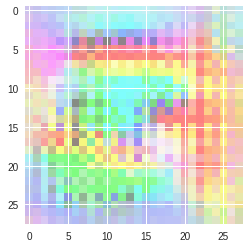

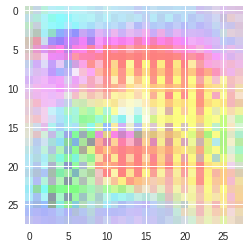

Epoch [19/50], Step [1/10], d_loss: 0.1163, g_loss: 7.2801, D(x): 0.98, D(G(z)): 0.05
Epoch [19/50], Step [2/10], d_loss: 0.1413, g_loss: 7.3273, D(x): 0.98, D(G(z)): 0.05
Epoch [19/50], Step [3/10], d_loss: 0.1516, g_loss: 7.1487, D(x): 0.97, D(G(z)): 0.06
Epoch [19/50], Step [4/10], d_loss: 0.1860, g_loss: 7.1099, D(x): 0.96, D(G(z)): 0.06
Epoch [19/50], Step [5/10], d_loss: 0.1922, g_loss: 7.0976, D(x): 0.96, D(G(z)): 0.06
Epoch [19/50], Step [6/10], d_loss: 0.2113, g_loss: 6.9612, D(x): 0.96, D(G(z)): 0.07
Epoch [19/50], Step [7/10], d_loss: 0.2373, g_loss: 6.9462, D(x): 0.95, D(G(z)): 0.07
Epoch [19/50], Step [8/10], d_loss: 0.2413, g_loss: 6.6714, D(x): 0.95, D(G(z)): 0.08
Epoch [19/50], Step [9/10], d_loss: 0.2638, g_loss: 6.6807, D(x): 0.94, D(G(z)): 0.08
Epoch [19/50], Step [10/10], d_loss: 0.2867, g_loss: 6.5418, D(x): 0.94, D(G(z)): 0.09


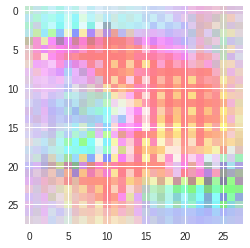

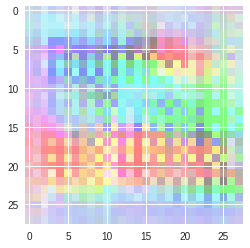

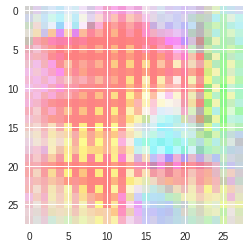

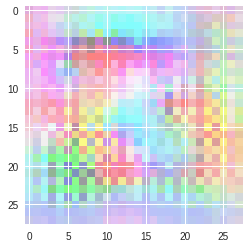

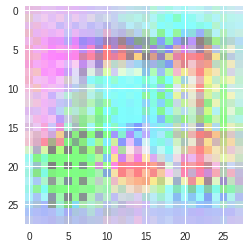

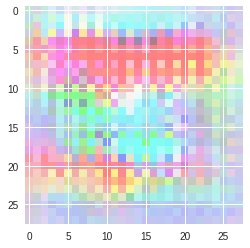

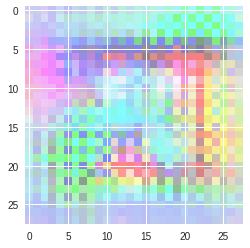

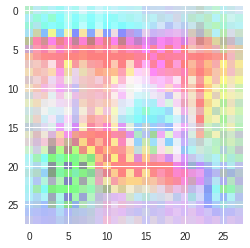

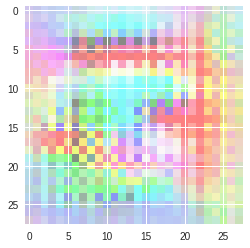

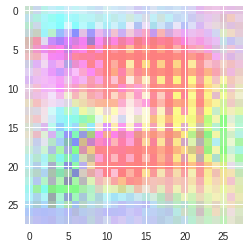

Epoch [20/50], Step [1/10], d_loss: 0.2212, g_loss: 6.4782, D(x): 0.97, D(G(z)): 0.09
Epoch [20/50], Step [2/10], d_loss: 0.2619, g_loss: 6.5506, D(x): 0.95, D(G(z)): 0.09
Epoch [20/50], Step [3/10], d_loss: 0.2755, g_loss: 6.6435, D(x): 0.94, D(G(z)): 0.09
Epoch [20/50], Step [4/10], d_loss: 0.2900, g_loss: 6.7199, D(x): 0.93, D(G(z)): 0.08
Epoch [20/50], Step [5/10], d_loss: 0.3024, g_loss: 6.7119, D(x): 0.92, D(G(z)): 0.07
Epoch [20/50], Step [6/10], d_loss: 0.3258, g_loss: 6.7597, D(x): 0.90, D(G(z)): 0.06
Epoch [20/50], Step [7/10], d_loss: 0.3459, g_loss: 6.7176, D(x): 0.89, D(G(z)): 0.05
Epoch [20/50], Step [8/10], d_loss: 0.3000, g_loss: 6.6580, D(x): 0.91, D(G(z)): 0.05
Epoch [20/50], Step [9/10], d_loss: 0.3052, g_loss: 6.5945, D(x): 0.90, D(G(z)): 0.04
Epoch [20/50], Step [10/10], d_loss: 0.2579, g_loss: 6.4053, D(x): 0.91, D(G(z)): 0.04


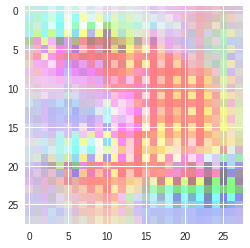

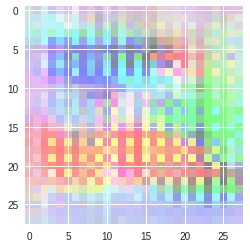

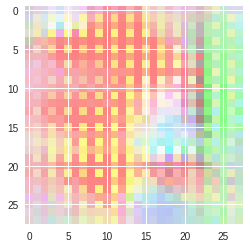

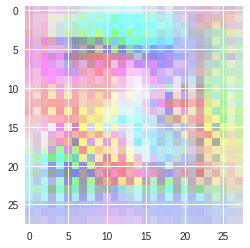

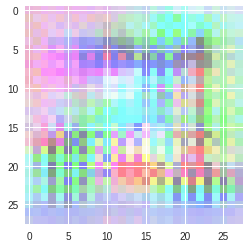

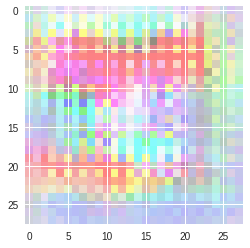

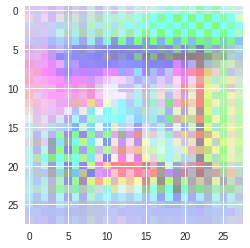

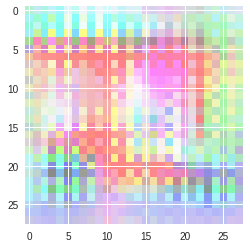

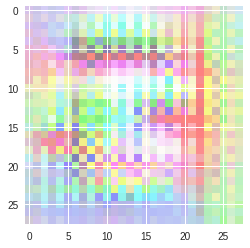

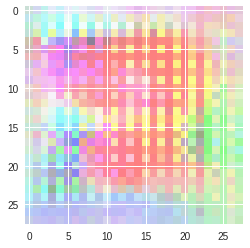

Epoch [21/50], Step [1/10], d_loss: 0.1279, g_loss: 6.2830, D(x): 0.96, D(G(z)): 0.04
Epoch [21/50], Step [2/10], d_loss: 0.1741, g_loss: 6.2011, D(x): 0.95, D(G(z)): 0.04
Epoch [21/50], Step [3/10], d_loss: 0.1593, g_loss: 6.1751, D(x): 0.95, D(G(z)): 0.04
Epoch [21/50], Step [4/10], d_loss: 0.1765, g_loss: 6.0449, D(x): 0.95, D(G(z)): 0.05
Epoch [21/50], Step [5/10], d_loss: 0.1653, g_loss: 6.0031, D(x): 0.95, D(G(z)): 0.04
Epoch [21/50], Step [6/10], d_loss: 0.1762, g_loss: 5.9412, D(x): 0.95, D(G(z)): 0.05
Epoch [21/50], Step [7/10], d_loss: 0.1863, g_loss: 5.8549, D(x): 0.94, D(G(z)): 0.05
Epoch [21/50], Step [8/10], d_loss: 0.1649, g_loss: 5.8681, D(x): 0.95, D(G(z)): 0.05
Epoch [21/50], Step [9/10], d_loss: 0.1696, g_loss: 5.9968, D(x): 0.95, D(G(z)): 0.05
Epoch [21/50], Step [10/10], d_loss: 0.1568, g_loss: 5.9954, D(x): 0.96, D(G(z)): 0.05


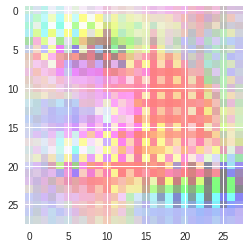

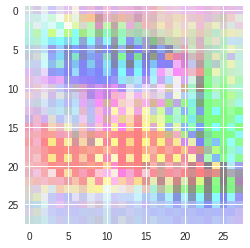

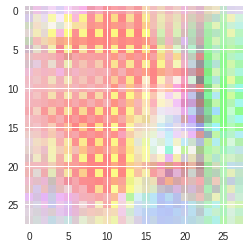

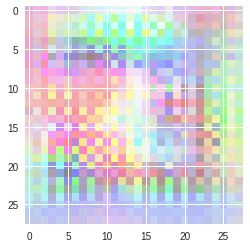

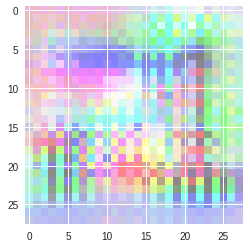

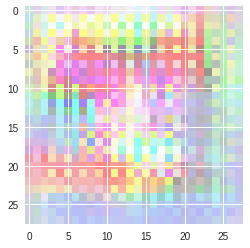

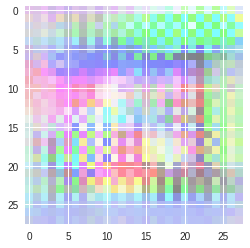

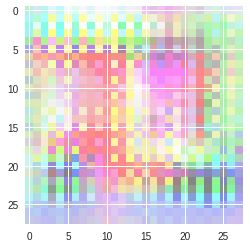

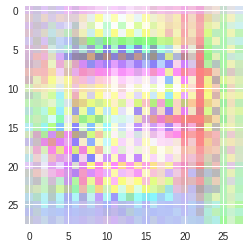

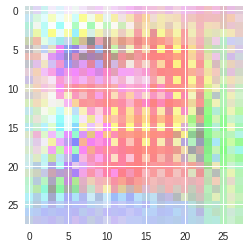

Epoch [22/50], Step [1/10], d_loss: 0.1064, g_loss: 6.0654, D(x): 0.98, D(G(z)): 0.05
Epoch [22/50], Step [2/10], d_loss: 0.1270, g_loss: 6.1314, D(x): 0.97, D(G(z)): 0.05
Epoch [22/50], Step [3/10], d_loss: 0.1150, g_loss: 6.2651, D(x): 0.97, D(G(z)): 0.04
Epoch [22/50], Step [4/10], d_loss: 0.1229, g_loss: 6.3773, D(x): 0.97, D(G(z)): 0.04
Epoch [22/50], Step [5/10], d_loss: 0.1298, g_loss: 6.4248, D(x): 0.96, D(G(z)): 0.04
Epoch [22/50], Step [6/10], d_loss: 0.1338, g_loss: 6.5679, D(x): 0.96, D(G(z)): 0.04
Epoch [22/50], Step [7/10], d_loss: 0.1450, g_loss: 6.6153, D(x): 0.95, D(G(z)): 0.03
Epoch [22/50], Step [8/10], d_loss: 0.1117, g_loss: 6.5467, D(x): 0.96, D(G(z)): 0.04
Epoch [22/50], Step [9/10], d_loss: 0.1523, g_loss: 6.4491, D(x): 0.95, D(G(z)): 0.04
Epoch [22/50], Step [10/10], d_loss: 0.1446, g_loss: 6.3438, D(x): 0.95, D(G(z)): 0.04


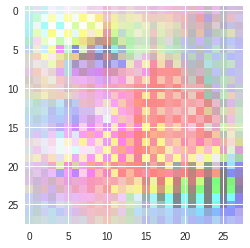

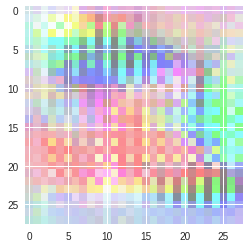

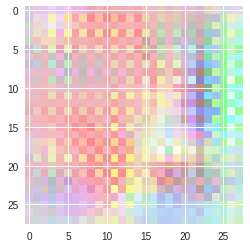

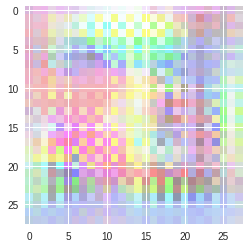

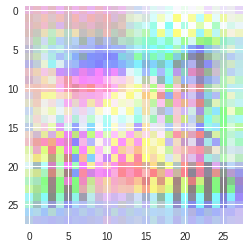

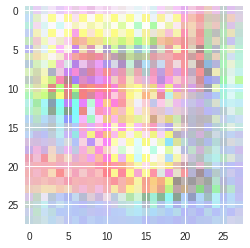

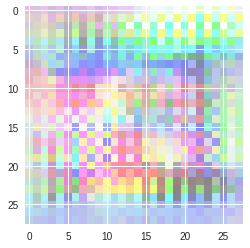

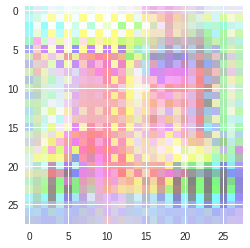

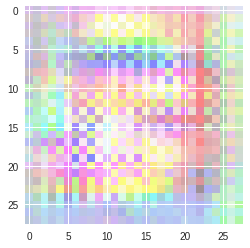

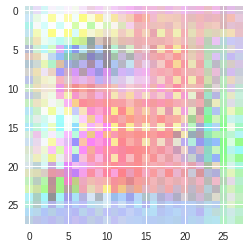

Epoch [23/50], Step [1/10], d_loss: 0.0887, g_loss: 6.2246, D(x): 0.98, D(G(z)): 0.04
Epoch [23/50], Step [2/10], d_loss: 0.1151, g_loss: 6.2118, D(x): 0.97, D(G(z)): 0.04
Epoch [23/50], Step [3/10], d_loss: 0.1261, g_loss: 6.1099, D(x): 0.97, D(G(z)): 0.05
Epoch [23/50], Step [4/10], d_loss: 0.1347, g_loss: 6.0398, D(x): 0.97, D(G(z)): 0.05
Epoch [23/50], Step [5/10], d_loss: 0.1510, g_loss: 5.9972, D(x): 0.96, D(G(z)): 0.05
Epoch [23/50], Step [6/10], d_loss: 0.1610, g_loss: 6.0177, D(x): 0.95, D(G(z)): 0.05
Epoch [23/50], Step [7/10], d_loss: 0.1957, g_loss: 5.9620, D(x): 0.94, D(G(z)): 0.06
Epoch [23/50], Step [8/10], d_loss: 0.1501, g_loss: 6.0982, D(x): 0.96, D(G(z)): 0.06
Epoch [23/50], Step [9/10], d_loss: 0.2129, g_loss: 6.1057, D(x): 0.94, D(G(z)): 0.06
Epoch [23/50], Step [10/10], d_loss: 0.1984, g_loss: 6.2603, D(x): 0.95, D(G(z)): 0.06


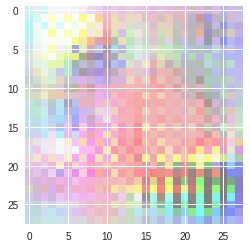

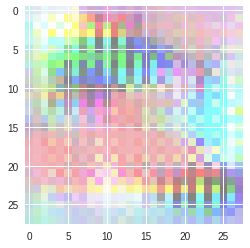

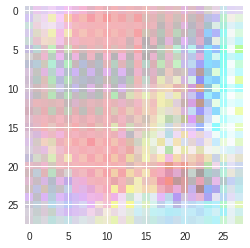

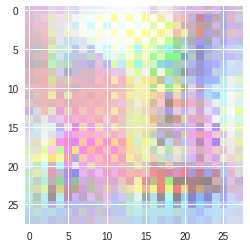

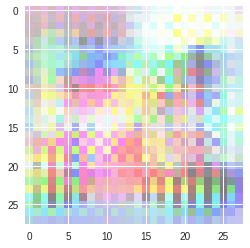

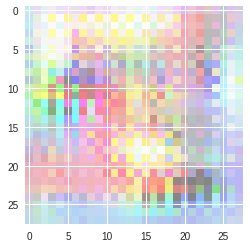

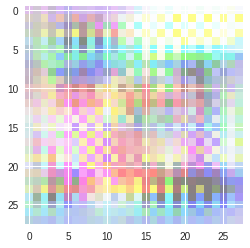

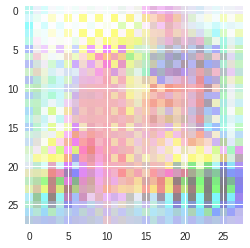

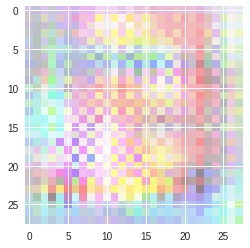

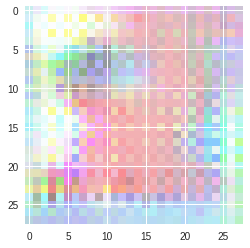

Epoch [24/50], Step [1/10], d_loss: 0.1251, g_loss: 6.3841, D(x): 0.98, D(G(z)): 0.06
Epoch [24/50], Step [2/10], d_loss: 0.1411, g_loss: 6.5323, D(x): 0.97, D(G(z)): 0.05
Epoch [24/50], Step [3/10], d_loss: 0.1661, g_loss: 6.5674, D(x): 0.96, D(G(z)): 0.06
Epoch [24/50], Step [4/10], d_loss: 0.1807, g_loss: 6.5913, D(x): 0.96, D(G(z)): 0.06
Epoch [24/50], Step [5/10], d_loss: 0.1901, g_loss: 6.6411, D(x): 0.95, D(G(z)): 0.06
Epoch [24/50], Step [6/10], d_loss: 0.2070, g_loss: 6.5654, D(x): 0.95, D(G(z)): 0.06
Epoch [24/50], Step [7/10], d_loss: 0.2721, g_loss: 6.4057, D(x): 0.93, D(G(z)): 0.08
Epoch [24/50], Step [8/10], d_loss: 0.2216, g_loss: 6.4765, D(x): 0.96, D(G(z)): 0.08
Epoch [24/50], Step [9/10], d_loss: 0.3112, g_loss: 6.3768, D(x): 0.93, D(G(z)): 0.09
Epoch [24/50], Step [10/10], d_loss: 0.2963, g_loss: 6.4509, D(x): 0.94, D(G(z)): 0.10


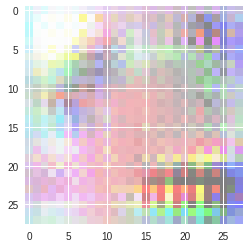

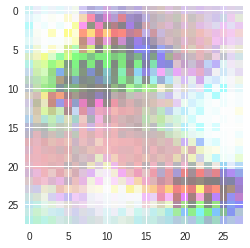

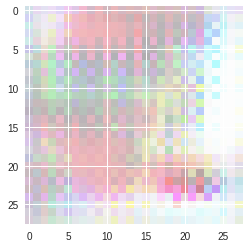

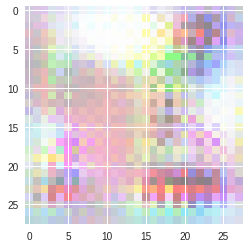

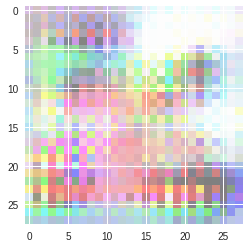

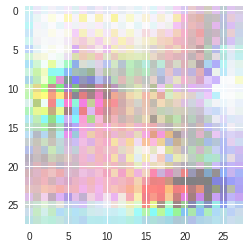

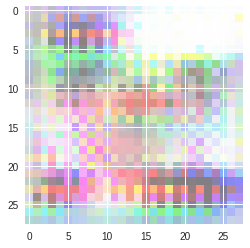

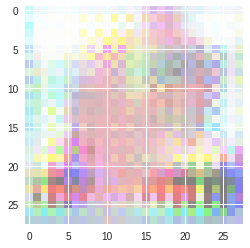

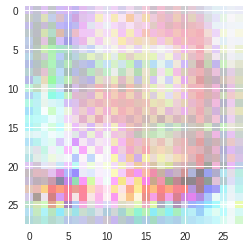

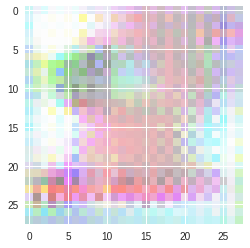

Epoch [25/50], Step [1/10], d_loss: 0.2019, g_loss: 6.6690, D(x): 0.98, D(G(z)): 0.10
Epoch [25/50], Step [2/10], d_loss: 0.2435, g_loss: 6.9192, D(x): 0.96, D(G(z)): 0.09
Epoch [25/50], Step [3/10], d_loss: 0.2432, g_loss: 7.1523, D(x): 0.94, D(G(z)): 0.08
Epoch [25/50], Step [4/10], d_loss: 0.2399, g_loss: 7.3276, D(x): 0.93, D(G(z)): 0.07
Epoch [25/50], Step [5/10], d_loss: 0.2832, g_loss: 7.4189, D(x): 0.92, D(G(z)): 0.06
Epoch [25/50], Step [6/10], d_loss: 0.2816, g_loss: 7.4226, D(x): 0.91, D(G(z)): 0.05
Epoch [25/50], Step [7/10], d_loss: 0.2798, g_loss: 7.3819, D(x): 0.91, D(G(z)): 0.05
Epoch [25/50], Step [8/10], d_loss: 0.1920, g_loss: 7.3120, D(x): 0.94, D(G(z)): 0.05
Epoch [25/50], Step [9/10], d_loss: 0.2405, g_loss: 7.3649, D(x): 0.93, D(G(z)): 0.04
Epoch [25/50], Step [10/10], d_loss: 0.1907, g_loss: 7.3668, D(x): 0.94, D(G(z)): 0.04


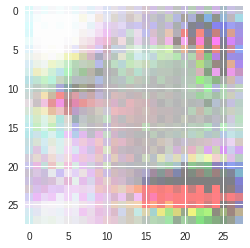

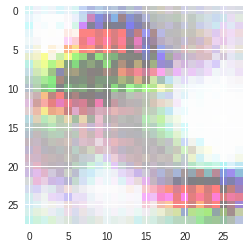

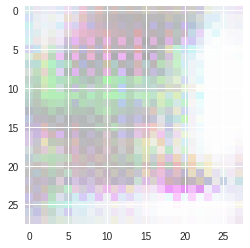

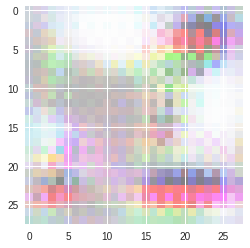

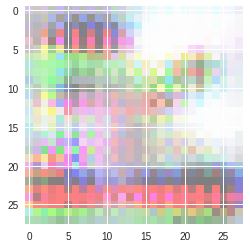

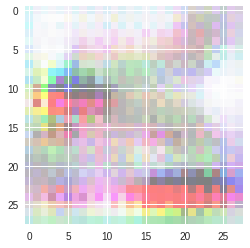

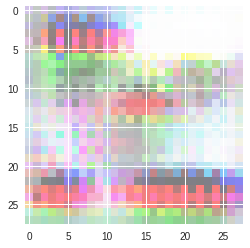

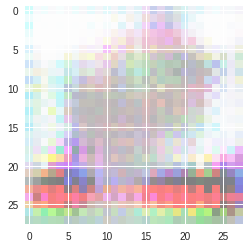

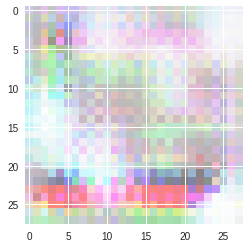

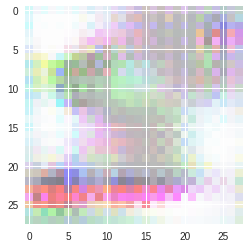

Epoch [26/50], Step [1/10], d_loss: 0.0883, g_loss: 7.3958, D(x): 0.98, D(G(z)): 0.04
Epoch [26/50], Step [2/10], d_loss: 0.1086, g_loss: 7.4514, D(x): 0.97, D(G(z)): 0.03
Epoch [26/50], Step [3/10], d_loss: 0.1184, g_loss: 7.2515, D(x): 0.96, D(G(z)): 0.04
Epoch [26/50], Step [4/10], d_loss: 0.1329, g_loss: 7.1648, D(x): 0.96, D(G(z)): 0.04
Epoch [26/50], Step [5/10], d_loss: 0.1496, g_loss: 6.9332, D(x): 0.96, D(G(z)): 0.05
Epoch [26/50], Step [6/10], d_loss: 0.1881, g_loss: 6.7236, D(x): 0.96, D(G(z)): 0.06
Epoch [26/50], Step [7/10], d_loss: 0.1910, g_loss: 6.6509, D(x): 0.96, D(G(z)): 0.07
Epoch [26/50], Step [8/10], d_loss: 0.1950, g_loss: 6.6039, D(x): 0.97, D(G(z)): 0.09
Epoch [26/50], Step [9/10], d_loss: 0.2510, g_loss: 6.6930, D(x): 0.96, D(G(z)): 0.09
Epoch [26/50], Step [10/10], d_loss: 0.2296, g_loss: 6.9085, D(x): 0.96, D(G(z)): 0.08


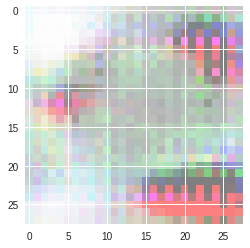

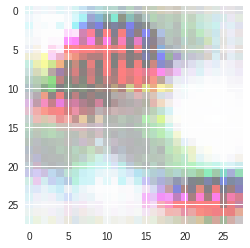

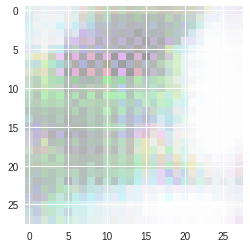

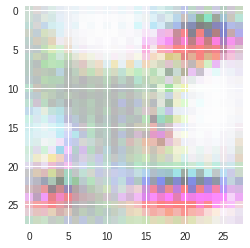

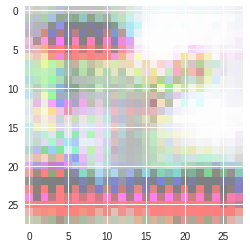

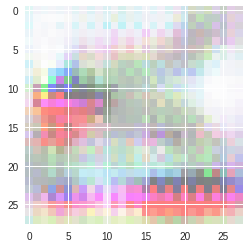

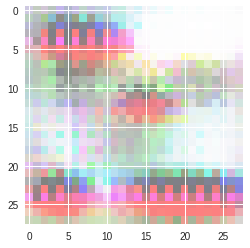

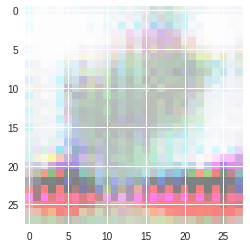

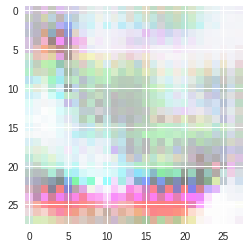

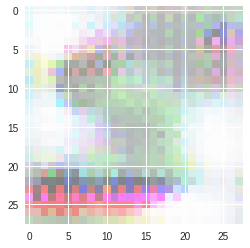

Epoch [27/50], Step [1/10], d_loss: 0.1747, g_loss: 7.1937, D(x): 0.97, D(G(z)): 0.08
Epoch [27/50], Step [2/10], d_loss: 0.1761, g_loss: 7.4073, D(x): 0.96, D(G(z)): 0.06
Epoch [27/50], Step [3/10], d_loss: 0.1899, g_loss: 7.7124, D(x): 0.95, D(G(z)): 0.05
Epoch [27/50], Step [4/10], d_loss: 0.2079, g_loss: 7.8531, D(x): 0.94, D(G(z)): 0.04
Epoch [27/50], Step [5/10], d_loss: 0.2253, g_loss: 7.8350, D(x): 0.93, D(G(z)): 0.04
Epoch [27/50], Step [6/10], d_loss: 0.2459, g_loss: 7.8713, D(x): 0.92, D(G(z)): 0.03
Epoch [27/50], Step [7/10], d_loss: 0.2200, g_loss: 7.6922, D(x): 0.93, D(G(z)): 0.04
Epoch [27/50], Step [8/10], d_loss: 0.1951, g_loss: 7.5163, D(x): 0.93, D(G(z)): 0.04
Epoch [27/50], Step [9/10], d_loss: 0.2448, g_loss: 7.2887, D(x): 0.93, D(G(z)): 0.04
Epoch [27/50], Step [10/10], d_loss: 0.2185, g_loss: 7.1188, D(x): 0.94, D(G(z)): 0.05


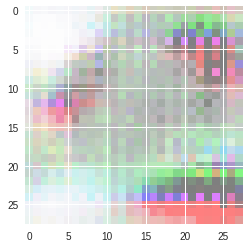

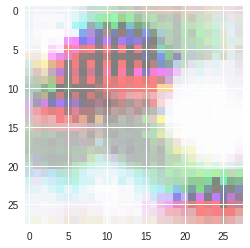

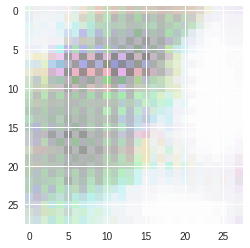

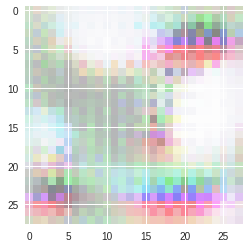

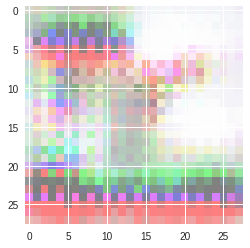

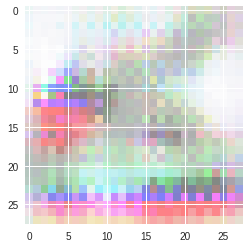

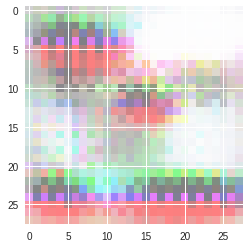

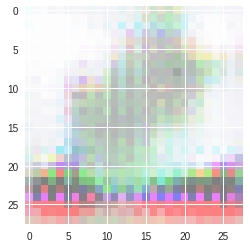

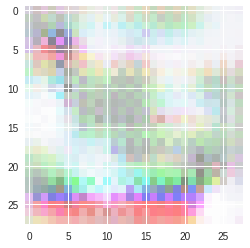

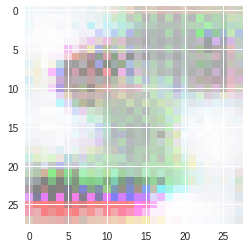

Epoch [28/50], Step [1/10], d_loss: 0.1740, g_loss: 7.0013, D(x): 0.96, D(G(z)): 0.06
Epoch [28/50], Step [2/10], d_loss: 0.1985, g_loss: 6.9357, D(x): 0.95, D(G(z)): 0.06
Epoch [28/50], Step [3/10], d_loss: 0.2057, g_loss: 6.9176, D(x): 0.95, D(G(z)): 0.07
Epoch [28/50], Step [4/10], d_loss: 0.2310, g_loss: 6.8770, D(x): 0.95, D(G(z)): 0.07
Epoch [28/50], Step [5/10], d_loss: 0.2156, g_loss: 6.9192, D(x): 0.94, D(G(z)): 0.06
Epoch [28/50], Step [6/10], d_loss: 0.2302, g_loss: 7.0319, D(x): 0.94, D(G(z)): 0.06
Epoch [28/50], Step [7/10], d_loss: 0.2081, g_loss: 7.0360, D(x): 0.95, D(G(z)): 0.06
Epoch [28/50], Step [8/10], d_loss: 0.1894, g_loss: 7.0410, D(x): 0.95, D(G(z)): 0.06
Epoch [28/50], Step [9/10], d_loss: 0.2472, g_loss: 6.9880, D(x): 0.94, D(G(z)): 0.06
Epoch [28/50], Step [10/10], d_loss: 0.2373, g_loss: 6.9421, D(x): 0.94, D(G(z)): 0.06


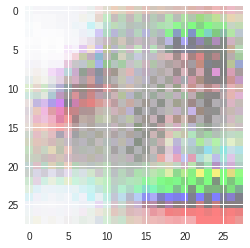

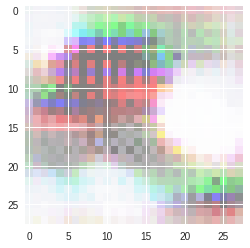

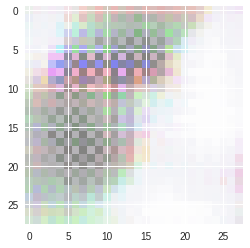

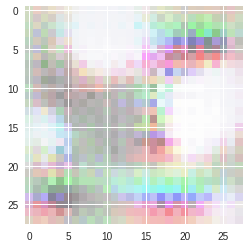

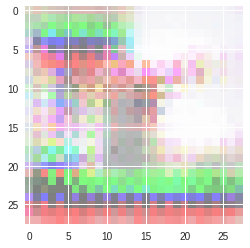

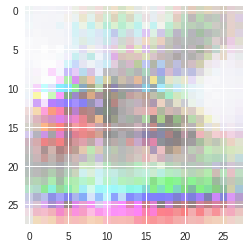

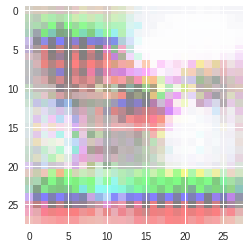

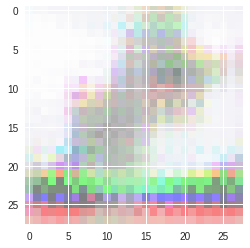

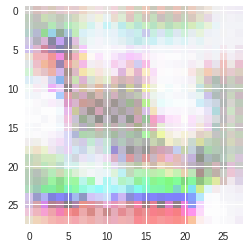

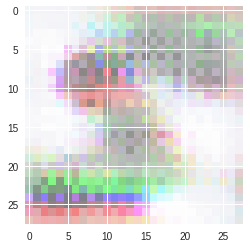

Epoch [29/50], Step [1/10], d_loss: 0.1989, g_loss: 6.8241, D(x): 0.96, D(G(z)): 0.06
Epoch [29/50], Step [2/10], d_loss: 0.2830, g_loss: 6.6732, D(x): 0.95, D(G(z)): 0.08
Epoch [29/50], Step [3/10], d_loss: 0.3253, g_loss: 6.5651, D(x): 0.94, D(G(z)): 0.09
Epoch [29/50], Step [4/10], d_loss: 0.3885, g_loss: 6.5649, D(x): 0.93, D(G(z)): 0.11
Epoch [29/50], Step [5/10], d_loss: 0.4497, g_loss: 6.5667, D(x): 0.91, D(G(z)): 0.11
Epoch [29/50], Step [6/10], d_loss: 0.4992, g_loss: 6.6237, D(x): 0.91, D(G(z)): 0.11
Epoch [29/50], Step [7/10], d_loss: 0.5137, g_loss: 6.7225, D(x): 0.91, D(G(z)): 0.12
Epoch [29/50], Step [8/10], d_loss: 0.4994, g_loss: 6.8214, D(x): 0.90, D(G(z)): 0.11
Epoch [29/50], Step [9/10], d_loss: 0.5760, g_loss: 6.8808, D(x): 0.87, D(G(z)): 0.11
Epoch [29/50], Step [10/10], d_loss: 0.5027, g_loss: 6.9467, D(x): 0.88, D(G(z)): 0.10


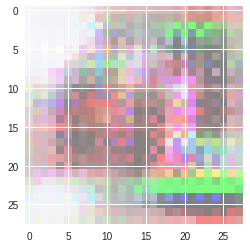

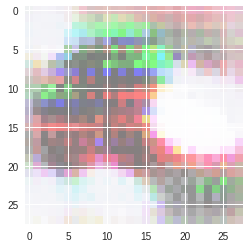

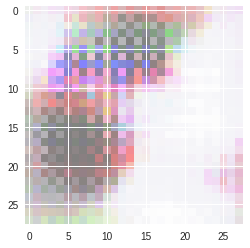

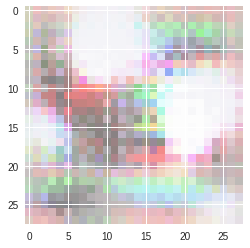

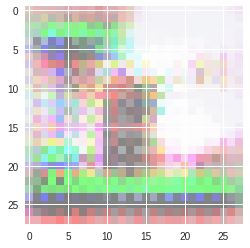

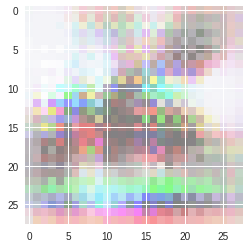

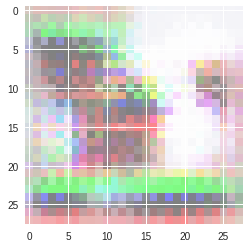

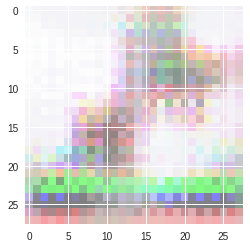

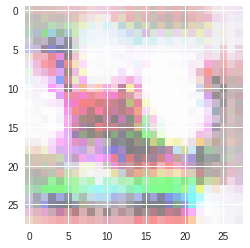

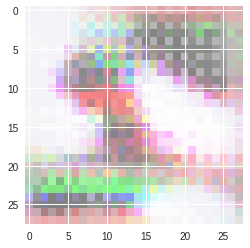

Epoch [30/50], Step [1/10], d_loss: 0.4192, g_loss: 6.9826, D(x): 0.90, D(G(z)): 0.09
Epoch [30/50], Step [2/10], d_loss: 0.4432, g_loss: 6.9735, D(x): 0.89, D(G(z)): 0.08
Epoch [30/50], Step [3/10], d_loss: 0.4164, g_loss: 6.7221, D(x): 0.88, D(G(z)): 0.08
Epoch [30/50], Step [4/10], d_loss: 0.4244, g_loss: 6.4940, D(x): 0.88, D(G(z)): 0.08
Epoch [30/50], Step [5/10], d_loss: 0.4419, g_loss: 6.1131, D(x): 0.88, D(G(z)): 0.09
Epoch [30/50], Step [6/10], d_loss: 0.4354, g_loss: 5.7907, D(x): 0.89, D(G(z)): 0.10
Epoch [30/50], Step [7/10], d_loss: 0.3895, g_loss: 5.7678, D(x): 0.90, D(G(z)): 0.10
Epoch [30/50], Step [8/10], d_loss: 0.3589, g_loss: 5.6682, D(x): 0.92, D(G(z)): 0.11
Epoch [30/50], Step [9/10], d_loss: 0.4004, g_loss: 5.7640, D(x): 0.90, D(G(z)): 0.11
Epoch [30/50], Step [10/10], d_loss: 0.3709, g_loss: 5.8507, D(x): 0.91, D(G(z)): 0.11


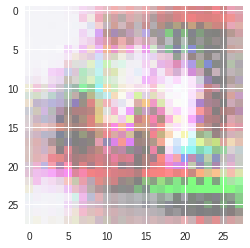

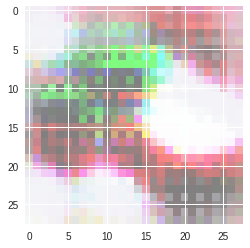

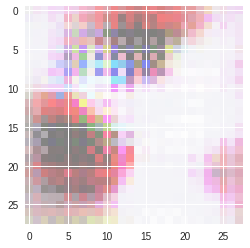

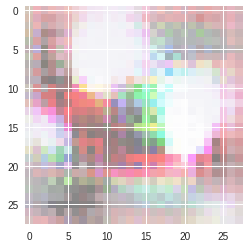

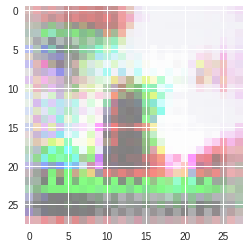

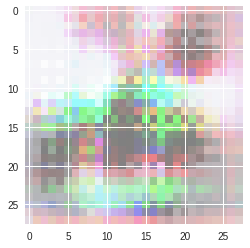

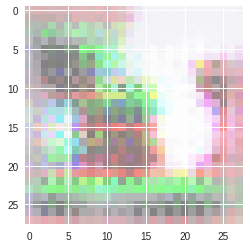

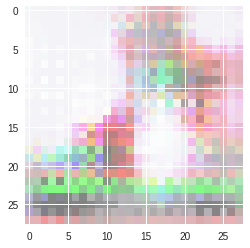

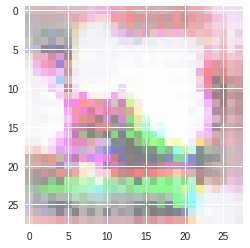

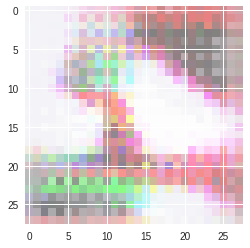

Epoch [31/50], Step [1/10], d_loss: 0.3047, g_loss: 6.0723, D(x): 0.92, D(G(z)): 0.09
Epoch [31/50], Step [2/10], d_loss: 0.3517, g_loss: 6.0690, D(x): 0.90, D(G(z)): 0.09
Epoch [31/50], Step [3/10], d_loss: 0.4063, g_loss: 5.9069, D(x): 0.88, D(G(z)): 0.09
Epoch [31/50], Step [4/10], d_loss: 0.4310, g_loss: 5.6713, D(x): 0.88, D(G(z)): 0.10
Epoch [31/50], Step [5/10], d_loss: 0.4796, g_loss: 5.4363, D(x): 0.87, D(G(z)): 0.11
Epoch [31/50], Step [6/10], d_loss: 0.4322, g_loss: 5.3437, D(x): 0.89, D(G(z)): 0.12
Epoch [31/50], Step [7/10], d_loss: 0.4134, g_loss: 5.4168, D(x): 0.90, D(G(z)): 0.13
Epoch [31/50], Step [8/10], d_loss: 0.3605, g_loss: 5.5753, D(x): 0.91, D(G(z)): 0.12
Epoch [31/50], Step [9/10], d_loss: 0.3662, g_loss: 5.9154, D(x): 0.90, D(G(z)): 0.10
Epoch [31/50], Step [10/10], d_loss: 0.3214, g_loss: 6.0950, D(x): 0.91, D(G(z)): 0.08


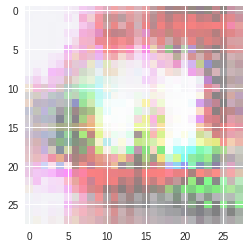

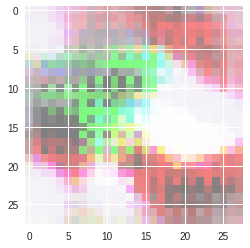

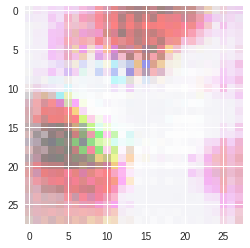

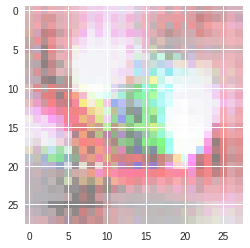

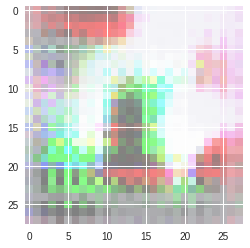

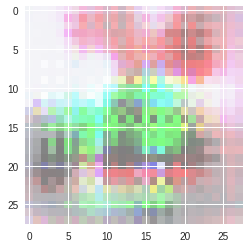

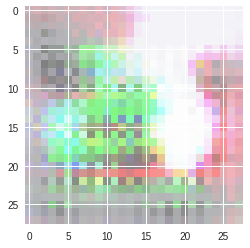

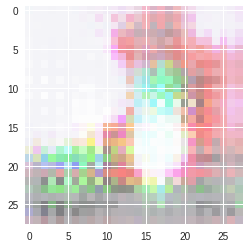

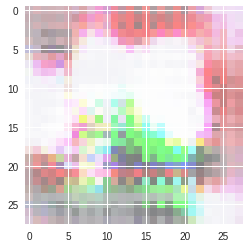

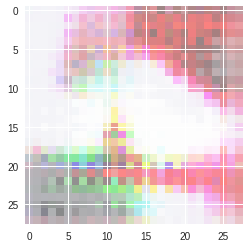

Epoch [32/50], Step [1/10], d_loss: 0.2811, g_loss: 6.2470, D(x): 0.91, D(G(z)): 0.07
Epoch [32/50], Step [2/10], d_loss: 0.3153, g_loss: 6.2584, D(x): 0.90, D(G(z)): 0.06
Epoch [32/50], Step [3/10], d_loss: 0.3228, g_loss: 6.2011, D(x): 0.90, D(G(z)): 0.06
Epoch [32/50], Step [4/10], d_loss: 0.2860, g_loss: 6.0894, D(x): 0.91, D(G(z)): 0.06
Epoch [32/50], Step [5/10], d_loss: 0.3104, g_loss: 5.9654, D(x): 0.90, D(G(z)): 0.06
Epoch [32/50], Step [6/10], d_loss: 0.2475, g_loss: 5.8619, D(x): 0.92, D(G(z)): 0.06
Epoch [32/50], Step [7/10], d_loss: 0.2345, g_loss: 5.8140, D(x): 0.93, D(G(z)): 0.06
Epoch [32/50], Step [8/10], d_loss: 0.2435, g_loss: 5.6963, D(x): 0.93, D(G(z)): 0.06
Epoch [32/50], Step [9/10], d_loss: 0.2375, g_loss: 5.5971, D(x): 0.94, D(G(z)): 0.06
Epoch [32/50], Step [10/10], d_loss: 0.2077, g_loss: 5.6430, D(x): 0.94, D(G(z)): 0.06


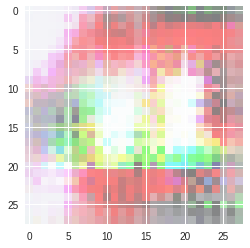

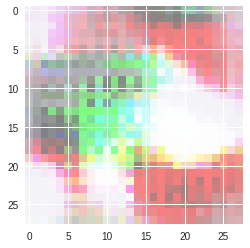

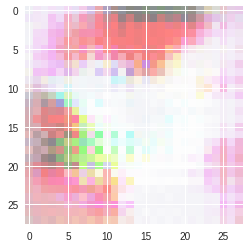

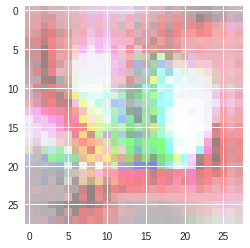

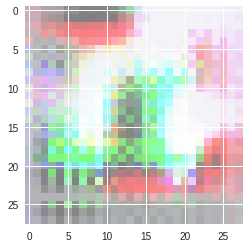

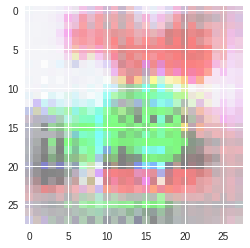

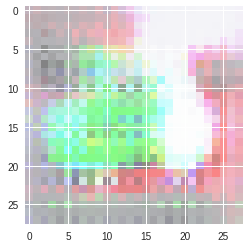

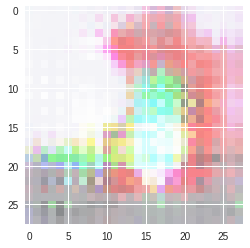

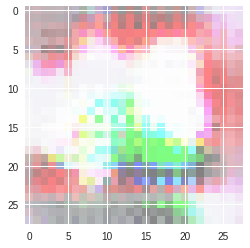

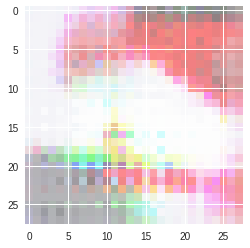

Epoch [33/50], Step [1/10], d_loss: 0.1447, g_loss: 5.6793, D(x): 0.96, D(G(z)): 0.06
Epoch [33/50], Step [2/10], d_loss: 0.1927, g_loss: 5.6974, D(x): 0.95, D(G(z)): 0.06
Epoch [33/50], Step [3/10], d_loss: 0.2034, g_loss: 5.6756, D(x): 0.94, D(G(z)): 0.06
Epoch [33/50], Step [4/10], d_loss: 0.2068, g_loss: 5.7413, D(x): 0.94, D(G(z)): 0.06
Epoch [33/50], Step [5/10], d_loss: 0.2411, g_loss: 5.6357, D(x): 0.93, D(G(z)): 0.06
Epoch [33/50], Step [6/10], d_loss: 0.2308, g_loss: 5.6004, D(x): 0.94, D(G(z)): 0.07
Epoch [33/50], Step [7/10], d_loss: 0.2410, g_loss: 5.6064, D(x): 0.94, D(G(z)): 0.07
Epoch [33/50], Step [8/10], d_loss: 0.2893, g_loss: 5.5180, D(x): 0.94, D(G(z)): 0.08
Epoch [33/50], Step [9/10], d_loss: 0.3012, g_loss: 5.5256, D(x): 0.94, D(G(z)): 0.09
Epoch [33/50], Step [10/10], d_loss: 0.2960, g_loss: 5.5712, D(x): 0.94, D(G(z)): 0.09


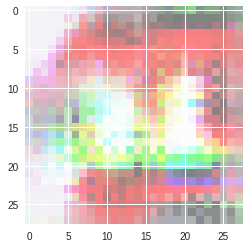

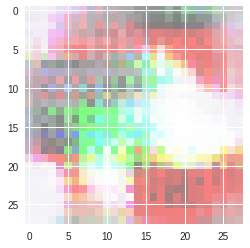

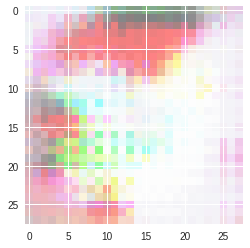

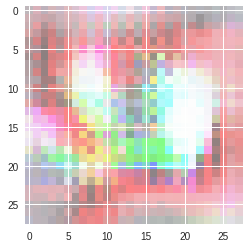

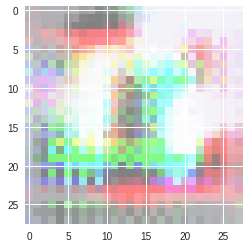

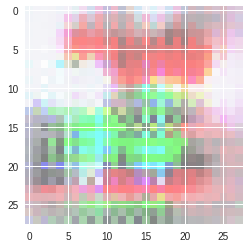

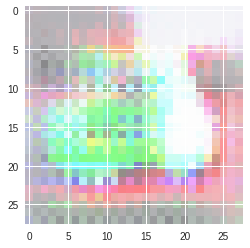

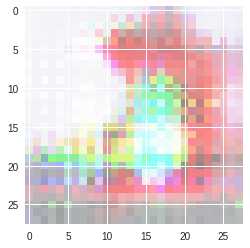

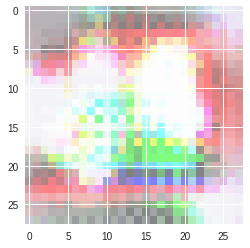

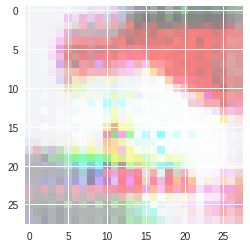

Epoch [34/50], Step [1/10], d_loss: 0.2267, g_loss: 5.6400, D(x): 0.96, D(G(z)): 0.10
Epoch [34/50], Step [2/10], d_loss: 0.3055, g_loss: 5.8287, D(x): 0.94, D(G(z)): 0.10
Epoch [34/50], Step [3/10], d_loss: 0.3556, g_loss: 5.8822, D(x): 0.93, D(G(z)): 0.10
Epoch [34/50], Step [4/10], d_loss: 0.3950, g_loss: 5.9276, D(x): 0.92, D(G(z)): 0.10
Epoch [34/50], Step [5/10], d_loss: 0.4621, g_loss: 5.8515, D(x): 0.90, D(G(z)): 0.12
Epoch [34/50], Step [6/10], d_loss: 0.5473, g_loss: 5.8312, D(x): 0.89, D(G(z)): 0.13
Epoch [34/50], Step [7/10], d_loss: 0.5915, g_loss: 5.8266, D(x): 0.89, D(G(z)): 0.15
Epoch [34/50], Step [8/10], d_loss: 0.7208, g_loss: 5.8589, D(x): 0.87, D(G(z)): 0.17
Epoch [34/50], Step [9/10], d_loss: 0.8865, g_loss: 5.9261, D(x): 0.84, D(G(z)): 0.19
Epoch [34/50], Step [10/10], d_loss: 1.0811, g_loss: 5.9035, D(x): 0.80, D(G(z)): 0.21


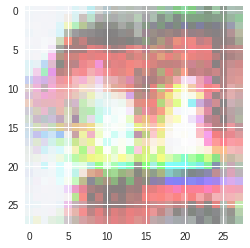

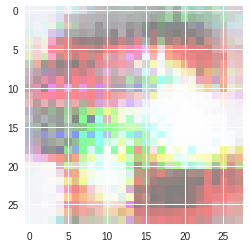

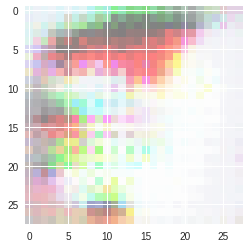

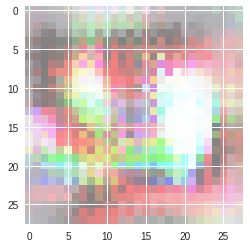

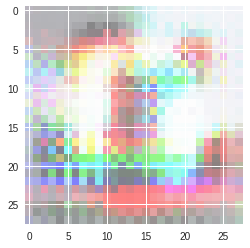

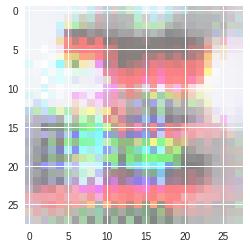

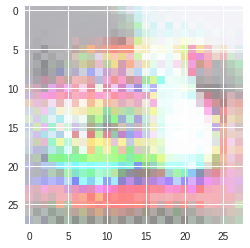

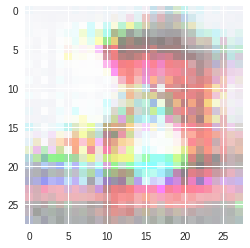

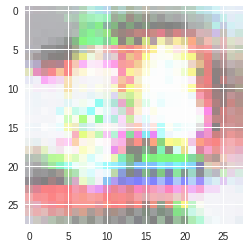

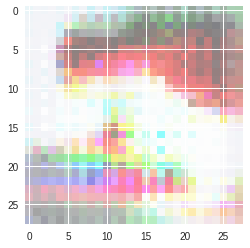

Epoch [35/50], Step [1/10], d_loss: 1.0297, g_loss: 6.1407, D(x): 0.83, D(G(z)): 0.22
Epoch [35/50], Step [2/10], d_loss: 1.4735, g_loss: 6.0439, D(x): 0.72, D(G(z)): 0.23
Epoch [35/50], Step [3/10], d_loss: 1.7390, g_loss: 5.9379, D(x): 0.68, D(G(z)): 0.25
Epoch [35/50], Step [4/10], d_loss: 1.9375, g_loss: 5.6967, D(x): 0.66, D(G(z)): 0.27
Epoch [35/50], Step [5/10], d_loss: 1.7503, g_loss: 5.7738, D(x): 0.69, D(G(z)): 0.27
Epoch [35/50], Step [6/10], d_loss: 1.5679, g_loss: 5.8860, D(x): 0.72, D(G(z)): 0.25
Epoch [35/50], Step [7/10], d_loss: 1.2992, g_loss: 6.1198, D(x): 0.76, D(G(z)): 0.23
Epoch [35/50], Step [8/10], d_loss: 1.0448, g_loss: 6.5804, D(x): 0.79, D(G(z)): 0.18
Epoch [35/50], Step [9/10], d_loss: 0.8607, g_loss: 6.8770, D(x): 0.80, D(G(z)): 0.13
Epoch [35/50], Step [10/10], d_loss: 0.6520, g_loss: 7.0108, D(x): 0.83, D(G(z)): 0.11


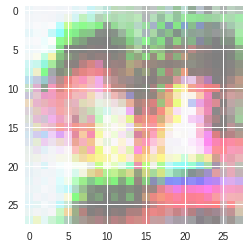

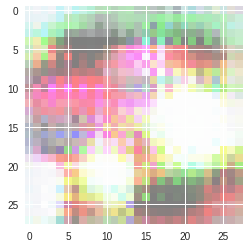

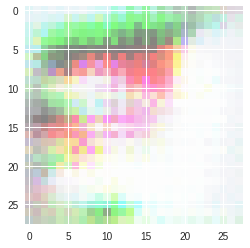

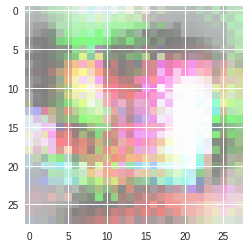

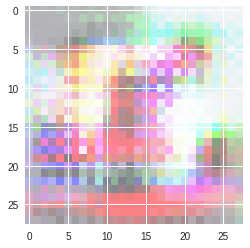

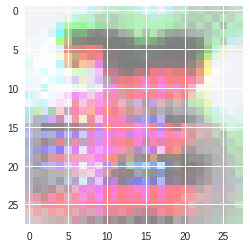

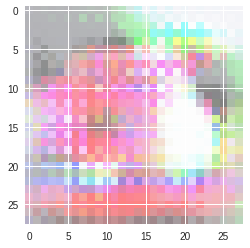

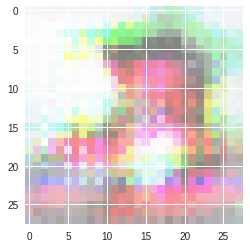

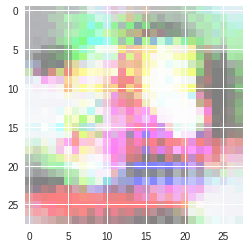

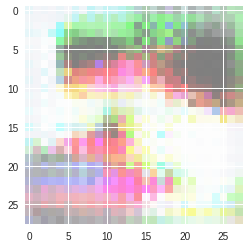

Epoch [36/50], Step [1/10], d_loss: 0.4267, g_loss: 7.1383, D(x): 0.90, D(G(z)): 0.10
Epoch [36/50], Step [2/10], d_loss: 0.4634, g_loss: 7.0919, D(x): 0.88, D(G(z)): 0.08
Epoch [36/50], Step [3/10], d_loss: 0.4011, g_loss: 7.1773, D(x): 0.89, D(G(z)): 0.08
Epoch [36/50], Step [4/10], d_loss: 0.3846, g_loss: 7.1692, D(x): 0.90, D(G(z)): 0.08
Epoch [36/50], Step [5/10], d_loss: 0.3439, g_loss: 6.9709, D(x): 0.91, D(G(z)): 0.08
Epoch [36/50], Step [6/10], d_loss: 0.3385, g_loss: 6.9367, D(x): 0.92, D(G(z)): 0.08
Epoch [36/50], Step [7/10], d_loss: 0.2993, g_loss: 6.8967, D(x): 0.93, D(G(z)): 0.08
Epoch [36/50], Step [8/10], d_loss: 0.3050, g_loss: 6.7230, D(x): 0.93, D(G(z)): 0.08
Epoch [36/50], Step [9/10], d_loss: 0.3037, g_loss: 6.8081, D(x): 0.94, D(G(z)): 0.08
Epoch [36/50], Step [10/10], d_loss: 0.2649, g_loss: 6.6905, D(x): 0.95, D(G(z)): 0.08


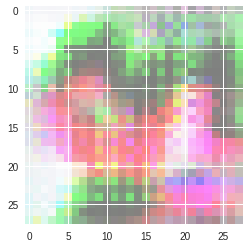

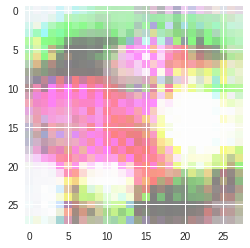

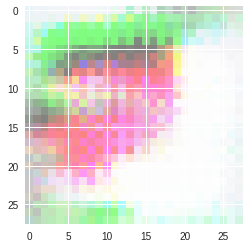

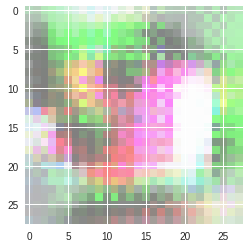

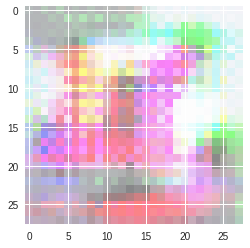

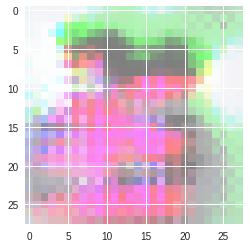

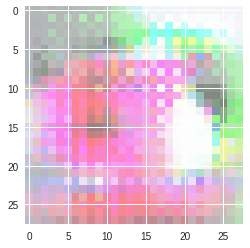

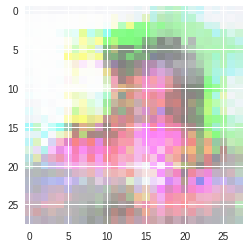

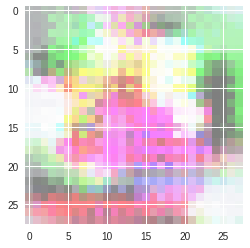

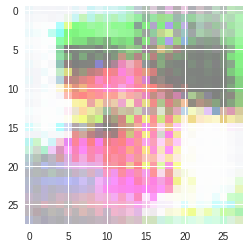

Epoch [37/50], Step [1/10], d_loss: 0.2127, g_loss: 6.8056, D(x): 0.97, D(G(z)): 0.08
Epoch [37/50], Step [2/10], d_loss: 0.2299, g_loss: 6.7600, D(x): 0.95, D(G(z)): 0.07
Epoch [37/50], Step [3/10], d_loss: 0.2110, g_loss: 6.7486, D(x): 0.95, D(G(z)): 0.07
Epoch [37/50], Step [4/10], d_loss: 0.2375, g_loss: 6.7270, D(x): 0.94, D(G(z)): 0.07
Epoch [37/50], Step [5/10], d_loss: 0.2374, g_loss: 6.6796, D(x): 0.93, D(G(z)): 0.07
Epoch [37/50], Step [6/10], d_loss: 0.2193, g_loss: 6.5744, D(x): 0.93, D(G(z)): 0.06
Epoch [37/50], Step [7/10], d_loss: 0.2308, g_loss: 6.5340, D(x): 0.93, D(G(z)): 0.06
Epoch [37/50], Step [8/10], d_loss: 0.2455, g_loss: 6.4377, D(x): 0.92, D(G(z)): 0.06
Epoch [37/50], Step [9/10], d_loss: 0.2308, g_loss: 6.2225, D(x): 0.93, D(G(z)): 0.07
Epoch [37/50], Step [10/10], d_loss: 0.2145, g_loss: 6.1760, D(x): 0.94, D(G(z)): 0.07


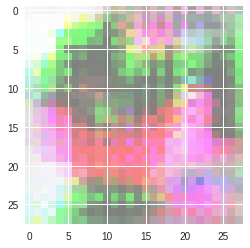

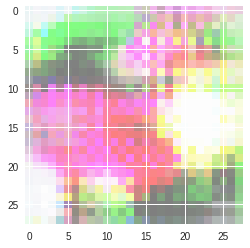

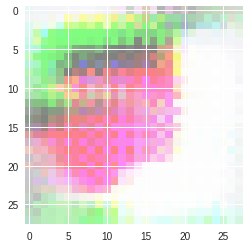

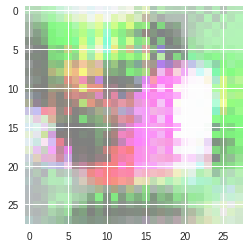

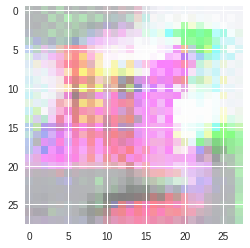

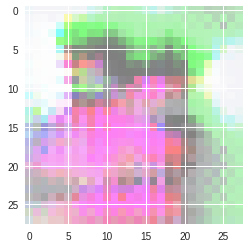

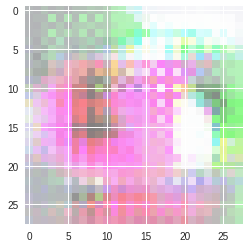

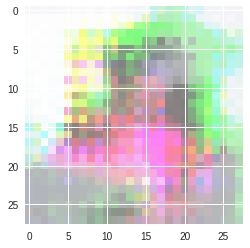

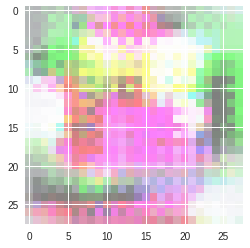

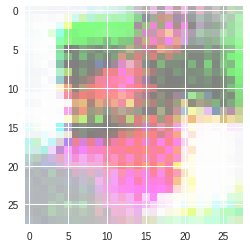

Epoch [38/50], Step [1/10], d_loss: 0.1623, g_loss: 6.1590, D(x): 0.96, D(G(z)): 0.06
Epoch [38/50], Step [2/10], d_loss: 0.1926, g_loss: 6.0485, D(x): 0.95, D(G(z)): 0.07
Epoch [38/50], Step [3/10], d_loss: 0.2053, g_loss: 6.1178, D(x): 0.94, D(G(z)): 0.07
Epoch [38/50], Step [4/10], d_loss: 0.1950, g_loss: 6.1507, D(x): 0.94, D(G(z)): 0.06
Epoch [38/50], Step [5/10], d_loss: 0.2015, g_loss: 6.2032, D(x): 0.94, D(G(z)): 0.06
Epoch [38/50], Step [6/10], d_loss: 0.1895, g_loss: 6.2996, D(x): 0.94, D(G(z)): 0.06
Epoch [38/50], Step [7/10], d_loss: 0.1735, g_loss: 6.4043, D(x): 0.94, D(G(z)): 0.05
Epoch [38/50], Step [8/10], d_loss: 0.2029, g_loss: 6.2870, D(x): 0.93, D(G(z)): 0.05
Epoch [38/50], Step [9/10], d_loss: 0.1510, g_loss: 6.3371, D(x): 0.95, D(G(z)): 0.05
Epoch [38/50], Step [10/10], d_loss: 0.1319, g_loss: 6.3356, D(x): 0.96, D(G(z)): 0.04


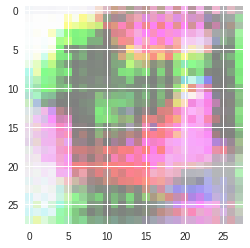

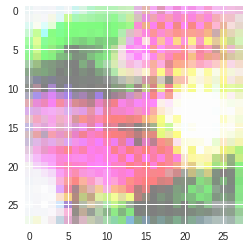

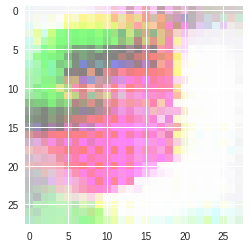

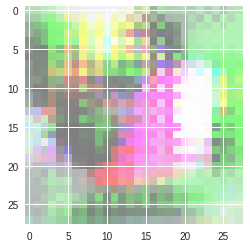

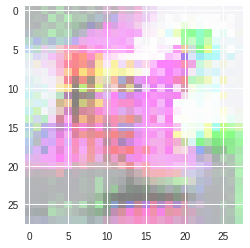

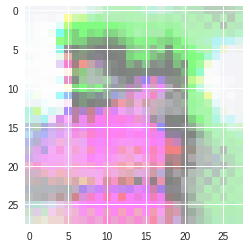

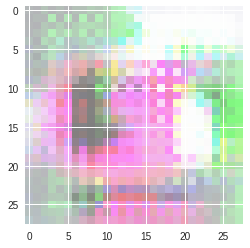

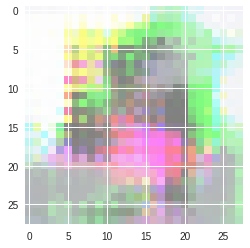

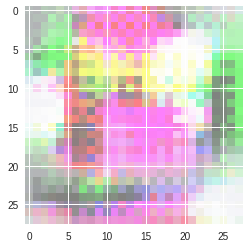

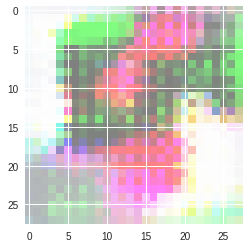

Epoch [39/50], Step [1/10], d_loss: 0.1015, g_loss: 6.3368, D(x): 0.97, D(G(z)): 0.04
Epoch [39/50], Step [2/10], d_loss: 0.1094, g_loss: 6.4421, D(x): 0.97, D(G(z)): 0.04
Epoch [39/50], Step [3/10], d_loss: 0.1183, g_loss: 6.3764, D(x): 0.96, D(G(z)): 0.04
Epoch [39/50], Step [4/10], d_loss: 0.1197, g_loss: 6.3595, D(x): 0.96, D(G(z)): 0.04
Epoch [39/50], Step [5/10], d_loss: 0.1224, g_loss: 6.3365, D(x): 0.96, D(G(z)): 0.04
Epoch [39/50], Step [6/10], d_loss: 0.1209, g_loss: 6.3159, D(x): 0.96, D(G(z)): 0.04
Epoch [39/50], Step [7/10], d_loss: 0.1215, g_loss: 6.2381, D(x): 0.96, D(G(z)): 0.04
Epoch [39/50], Step [8/10], d_loss: 0.1377, g_loss: 6.1923, D(x): 0.96, D(G(z)): 0.04
Epoch [39/50], Step [9/10], d_loss: 0.1194, g_loss: 6.1972, D(x): 0.97, D(G(z)): 0.05
Epoch [39/50], Step [10/10], d_loss: 0.1215, g_loss: 6.0523, D(x): 0.97, D(G(z)): 0.05


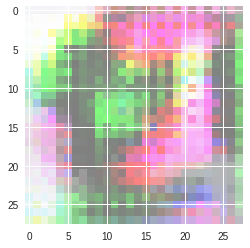

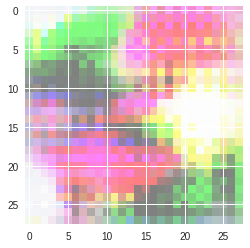

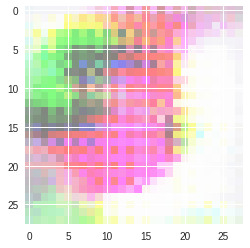

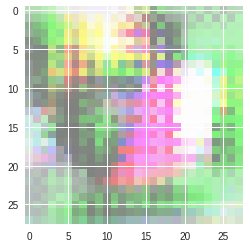

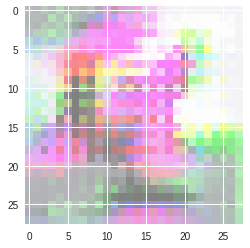

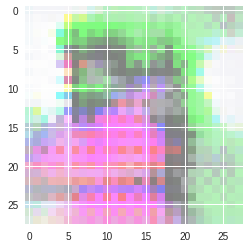

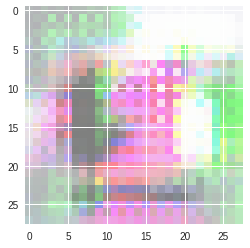

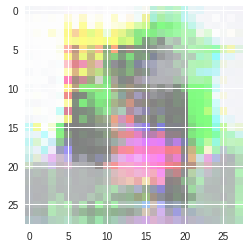

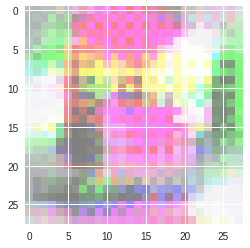

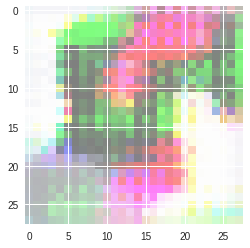

Epoch [40/50], Step [1/10], d_loss: 0.1001, g_loss: 6.0698, D(x): 0.98, D(G(z)): 0.05
Epoch [40/50], Step [2/10], d_loss: 0.1130, g_loss: 6.1513, D(x): 0.98, D(G(z)): 0.05
Epoch [40/50], Step [3/10], d_loss: 0.1309, g_loss: 6.1874, D(x): 0.97, D(G(z)): 0.05
Epoch [40/50], Step [4/10], d_loss: 0.1313, g_loss: 6.2385, D(x): 0.97, D(G(z)): 0.05
Epoch [40/50], Step [5/10], d_loss: 0.1470, g_loss: 6.1420, D(x): 0.96, D(G(z)): 0.05
Epoch [40/50], Step [6/10], d_loss: 0.1533, g_loss: 6.2022, D(x): 0.96, D(G(z)): 0.06
Epoch [40/50], Step [7/10], d_loss: 0.1559, g_loss: 6.1729, D(x): 0.96, D(G(z)): 0.05
Epoch [40/50], Step [8/10], d_loss: 0.1564, g_loss: 6.1891, D(x): 0.96, D(G(z)): 0.05
Epoch [40/50], Step [9/10], d_loss: 0.1542, g_loss: 6.1468, D(x): 0.96, D(G(z)): 0.05
Epoch [40/50], Step [10/10], d_loss: 0.1502, g_loss: 6.1136, D(x): 0.96, D(G(z)): 0.06


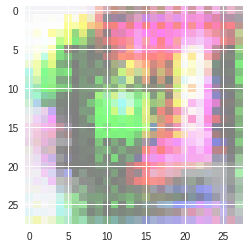

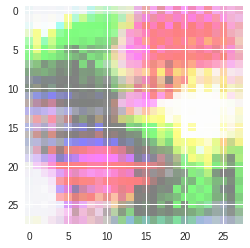

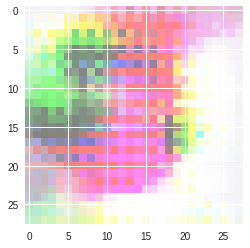

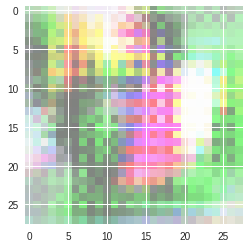

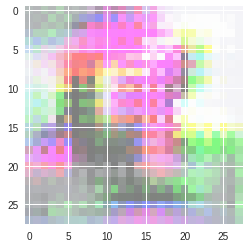

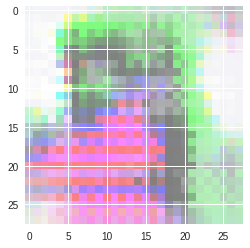

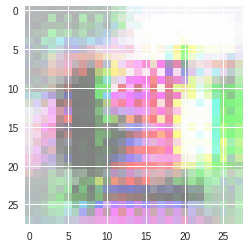

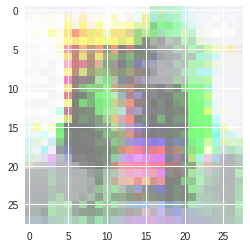

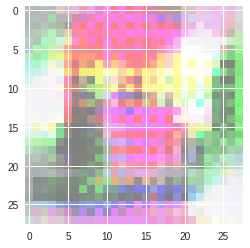

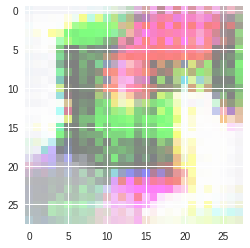

Epoch [41/50], Step [1/10], d_loss: 0.1330, g_loss: 6.0980, D(x): 0.97, D(G(z)): 0.06
Epoch [41/50], Step [2/10], d_loss: 0.1506, g_loss: 6.0723, D(x): 0.97, D(G(z)): 0.06
Epoch [41/50], Step [3/10], d_loss: 0.1732, g_loss: 5.9917, D(x): 0.96, D(G(z)): 0.06
Epoch [41/50], Step [4/10], d_loss: 0.1833, g_loss: 5.9872, D(x): 0.96, D(G(z)): 0.06
Epoch [41/50], Step [5/10], d_loss: 0.1964, g_loss: 5.9683, D(x): 0.95, D(G(z)): 0.06
Epoch [41/50], Step [6/10], d_loss: 0.1972, g_loss: 5.8823, D(x): 0.95, D(G(z)): 0.07
Epoch [41/50], Step [7/10], d_loss: 0.2062, g_loss: 5.7933, D(x): 0.95, D(G(z)): 0.07
Epoch [41/50], Step [8/10], d_loss: 0.1998, g_loss: 5.7944, D(x): 0.96, D(G(z)): 0.07
Epoch [41/50], Step [9/10], d_loss: 0.2023, g_loss: 5.7591, D(x): 0.95, D(G(z)): 0.07
Epoch [41/50], Step [10/10], d_loss: 0.2004, g_loss: 5.8260, D(x): 0.96, D(G(z)): 0.07


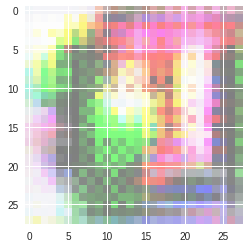

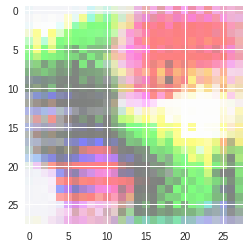

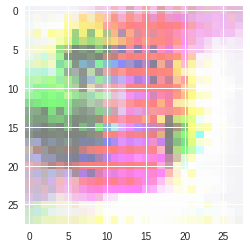

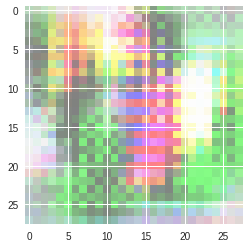

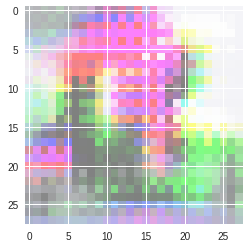

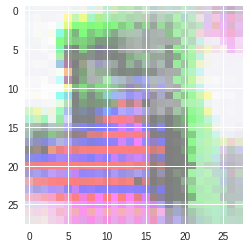

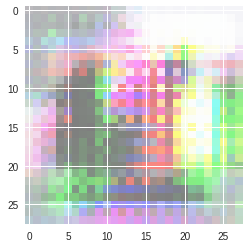

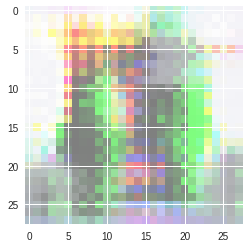

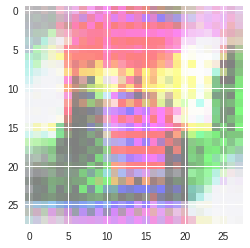

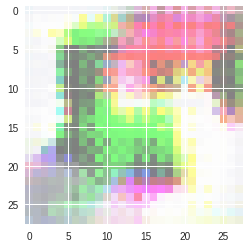

Epoch [42/50], Step [1/10], d_loss: 0.1623, g_loss: 5.9750, D(x): 0.97, D(G(z)): 0.07
Epoch [42/50], Step [2/10], d_loss: 0.1843, g_loss: 6.0149, D(x): 0.96, D(G(z)): 0.07
Epoch [42/50], Step [3/10], d_loss: 0.2062, g_loss: 6.0330, D(x): 0.95, D(G(z)): 0.07
Epoch [42/50], Step [4/10], d_loss: 0.1970, g_loss: 6.0537, D(x): 0.95, D(G(z)): 0.06
Epoch [42/50], Step [5/10], d_loss: 0.2072, g_loss: 6.0964, D(x): 0.94, D(G(z)): 0.06
Epoch [42/50], Step [6/10], d_loss: 0.1920, g_loss: 5.9937, D(x): 0.94, D(G(z)): 0.06
Epoch [42/50], Step [7/10], d_loss: 0.2006, g_loss: 5.9296, D(x): 0.95, D(G(z)): 0.06
Epoch [42/50], Step [8/10], d_loss: 0.1837, g_loss: 5.8028, D(x): 0.95, D(G(z)): 0.06
Epoch [42/50], Step [9/10], d_loss: 0.1893, g_loss: 5.7458, D(x): 0.95, D(G(z)): 0.06
Epoch [42/50], Step [10/10], d_loss: 0.1803, g_loss: 5.7361, D(x): 0.96, D(G(z)): 0.06


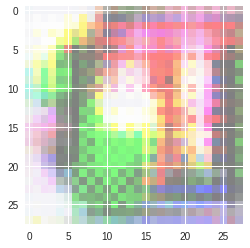

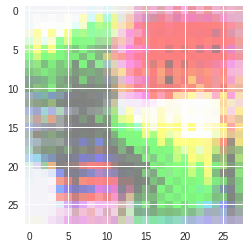

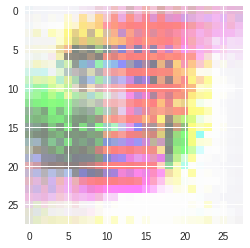

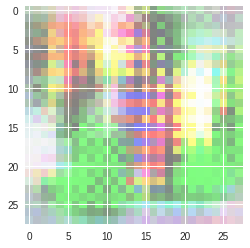

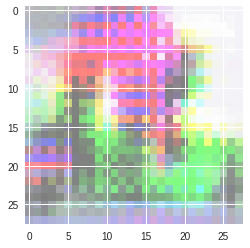

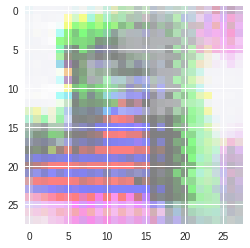

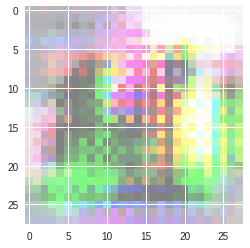

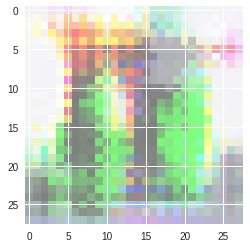

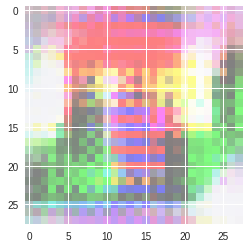

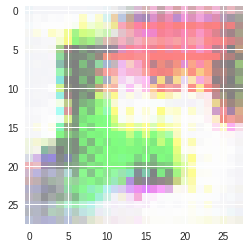

Epoch [43/50], Step [1/10], d_loss: 0.1559, g_loss: 5.6409, D(x): 0.97, D(G(z)): 0.07
Epoch [43/50], Step [2/10], d_loss: 0.1613, g_loss: 5.6961, D(x): 0.96, D(G(z)): 0.06
Epoch [43/50], Step [3/10], d_loss: 0.1920, g_loss: 5.7278, D(x): 0.95, D(G(z)): 0.06
Epoch [43/50], Step [4/10], d_loss: 0.1846, g_loss: 5.7289, D(x): 0.95, D(G(z)): 0.07
Epoch [43/50], Step [5/10], d_loss: 0.2012, g_loss: 5.7695, D(x): 0.94, D(G(z)): 0.06
Epoch [43/50], Step [6/10], d_loss: 0.1918, g_loss: 5.6753, D(x): 0.94, D(G(z)): 0.06
Epoch [43/50], Step [7/10], d_loss: 0.1957, g_loss: 5.5766, D(x): 0.94, D(G(z)): 0.06
Epoch [43/50], Step [8/10], d_loss: 0.1767, g_loss: 5.5040, D(x): 0.95, D(G(z)): 0.06
Epoch [43/50], Step [9/10], d_loss: 0.2042, g_loss: 5.4232, D(x): 0.95, D(G(z)): 0.07
Epoch [43/50], Step [10/10], d_loss: 0.1999, g_loss: 5.3255, D(x): 0.95, D(G(z)): 0.07


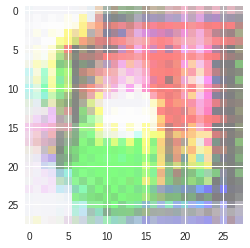

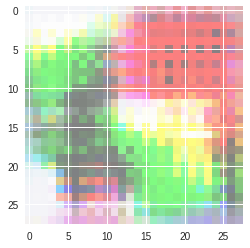

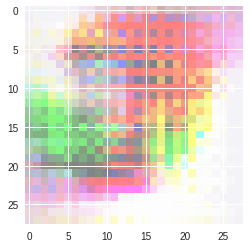

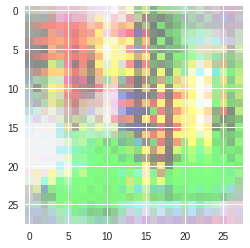

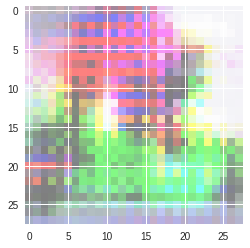

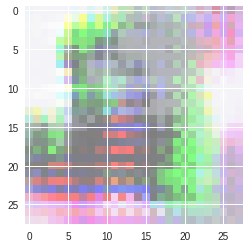

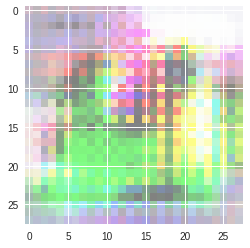

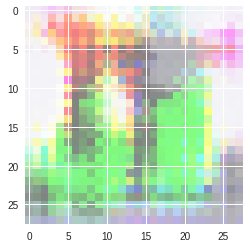

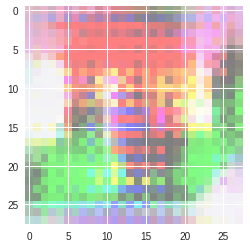

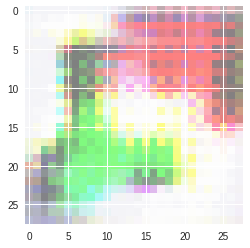

Epoch [44/50], Step [1/10], d_loss: 0.1707, g_loss: 5.3278, D(x): 0.97, D(G(z)): 0.08
Epoch [44/50], Step [2/10], d_loss: 0.1958, g_loss: 5.3824, D(x): 0.95, D(G(z)): 0.07
Epoch [44/50], Step [3/10], d_loss: 0.2303, g_loss: 5.3891, D(x): 0.94, D(G(z)): 0.08
Epoch [44/50], Step [4/10], d_loss: 0.2072, g_loss: 5.4474, D(x): 0.94, D(G(z)): 0.07
Epoch [44/50], Step [5/10], d_loss: 0.2443, g_loss: 5.3663, D(x): 0.93, D(G(z)): 0.07
Epoch [44/50], Step [6/10], d_loss: 0.2228, g_loss: 5.4168, D(x): 0.93, D(G(z)): 0.06
Epoch [44/50], Step [7/10], d_loss: 0.2239, g_loss: 5.3650, D(x): 0.93, D(G(z)): 0.07
Epoch [44/50], Step [8/10], d_loss: 0.1850, g_loss: 5.4041, D(x): 0.95, D(G(z)): 0.06
Epoch [44/50], Step [9/10], d_loss: 0.2006, g_loss: 5.3856, D(x): 0.94, D(G(z)): 0.06
Epoch [44/50], Step [10/10], d_loss: 0.1894, g_loss: 5.3750, D(x): 0.95, D(G(z)): 0.06


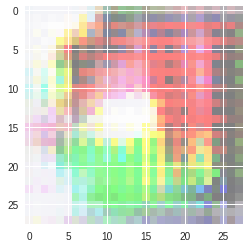

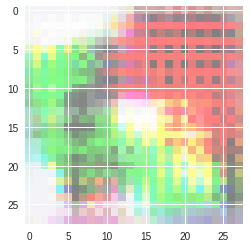

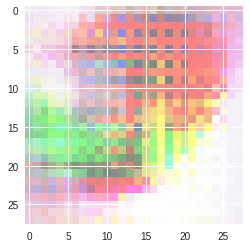

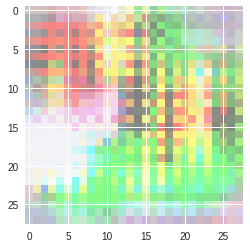

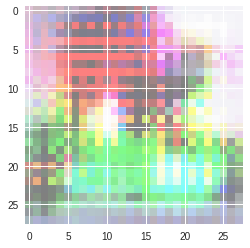

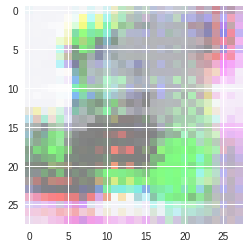

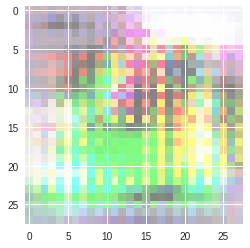

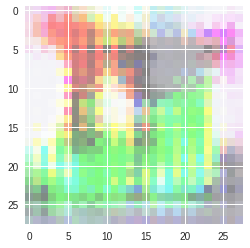

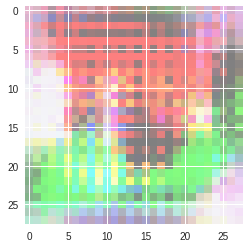

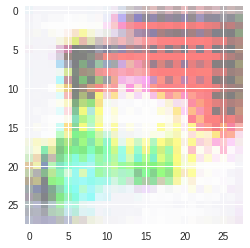

Epoch [45/50], Step [1/10], d_loss: 0.1242, g_loss: 5.5334, D(x): 0.97, D(G(z)): 0.06
Epoch [45/50], Step [2/10], d_loss: 0.1643, g_loss: 5.6327, D(x): 0.95, D(G(z)): 0.06
Epoch [45/50], Step [3/10], d_loss: 0.1751, g_loss: 5.7661, D(x): 0.94, D(G(z)): 0.05
Epoch [45/50], Step [4/10], d_loss: 0.1621, g_loss: 5.7914, D(x): 0.95, D(G(z)): 0.05
Epoch [45/50], Step [5/10], d_loss: 0.1659, g_loss: 5.7739, D(x): 0.94, D(G(z)): 0.04
Epoch [45/50], Step [6/10], d_loss: 0.1818, g_loss: 5.7063, D(x): 0.94, D(G(z)): 0.05
Epoch [45/50], Step [7/10], d_loss: 0.1769, g_loss: 5.6284, D(x): 0.94, D(G(z)): 0.05
Epoch [45/50], Step [8/10], d_loss: 0.1467, g_loss: 5.5533, D(x): 0.96, D(G(z)): 0.05
Epoch [45/50], Step [9/10], d_loss: 0.1830, g_loss: 5.4445, D(x): 0.95, D(G(z)): 0.06
Epoch [45/50], Step [10/10], d_loss: 0.1800, g_loss: 5.5907, D(x): 0.95, D(G(z)): 0.06


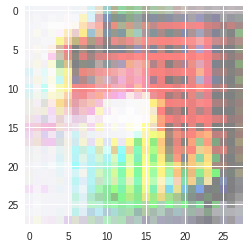

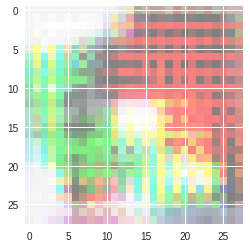

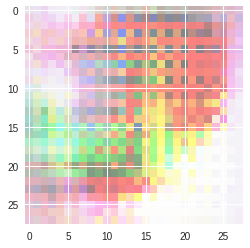

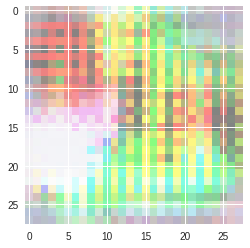

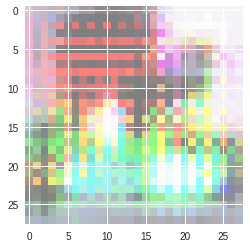

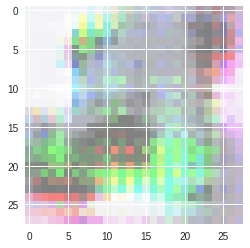

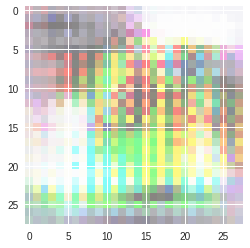

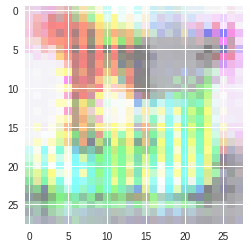

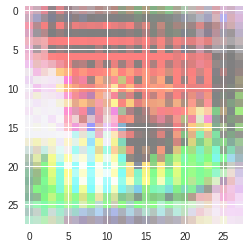

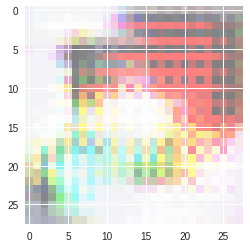

Epoch [46/50], Step [1/10], d_loss: 0.1177, g_loss: 5.6903, D(x): 0.98, D(G(z)): 0.06
Epoch [46/50], Step [2/10], d_loss: 0.1615, g_loss: 5.8005, D(x): 0.96, D(G(z)): 0.06
Epoch [46/50], Step [3/10], d_loss: 0.1722, g_loss: 5.9127, D(x): 0.95, D(G(z)): 0.05
Epoch [46/50], Step [4/10], d_loss: 0.1871, g_loss: 5.9182, D(x): 0.94, D(G(z)): 0.05
Epoch [46/50], Step [5/10], d_loss: 0.1910, g_loss: 5.8694, D(x): 0.93, D(G(z)): 0.05
Epoch [46/50], Step [6/10], d_loss: 0.2311, g_loss: 5.6750, D(x): 0.93, D(G(z)): 0.06
Epoch [46/50], Step [7/10], d_loss: 0.2356, g_loss: 5.5495, D(x): 0.93, D(G(z)): 0.06
Epoch [46/50], Step [8/10], d_loss: 0.1980, g_loss: 5.4975, D(x): 0.94, D(G(z)): 0.07
Epoch [46/50], Step [9/10], d_loss: 0.2465, g_loss: 5.4271, D(x): 0.93, D(G(z)): 0.08
Epoch [46/50], Step [10/10], d_loss: 0.2635, g_loss: 5.3464, D(x): 0.93, D(G(z)): 0.09


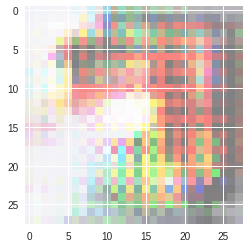

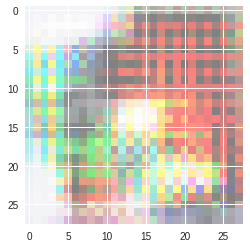

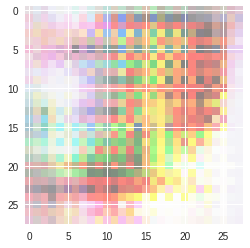

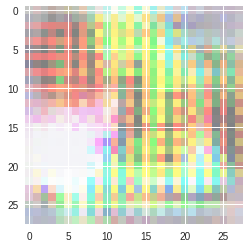

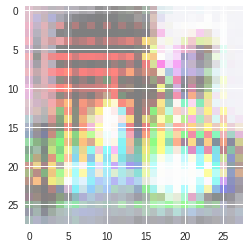

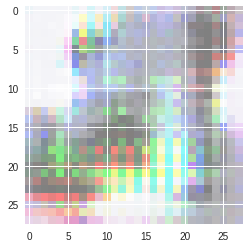

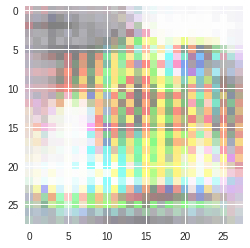

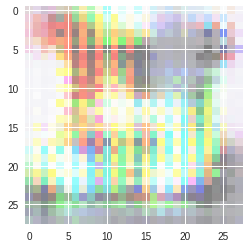

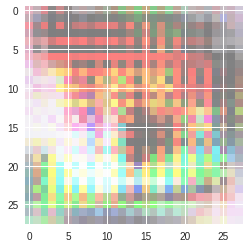

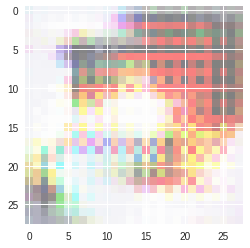

Epoch [47/50], Step [1/10], d_loss: 0.1760, g_loss: 5.6588, D(x): 0.96, D(G(z)): 0.08
Epoch [47/50], Step [2/10], d_loss: 0.2345, g_loss: 5.8672, D(x): 0.93, D(G(z)): 0.07
Epoch [47/50], Step [3/10], d_loss: 0.2601, g_loss: 5.8746, D(x): 0.90, D(G(z)): 0.06
Epoch [47/50], Step [4/10], d_loss: 0.3226, g_loss: 5.5589, D(x): 0.89, D(G(z)): 0.06
Epoch [47/50], Step [5/10], d_loss: 0.3081, g_loss: 5.2035, D(x): 0.89, D(G(z)): 0.07
Epoch [47/50], Step [6/10], d_loss: 0.3534, g_loss: 4.8285, D(x): 0.89, D(G(z)): 0.09
Epoch [47/50], Step [7/10], d_loss: 0.3686, g_loss: 4.5940, D(x): 0.90, D(G(z)): 0.11
Epoch [47/50], Step [8/10], d_loss: 0.3442, g_loss: 4.6584, D(x): 0.92, D(G(z)): 0.13
Epoch [47/50], Step [9/10], d_loss: 0.3717, g_loss: 4.9402, D(x): 0.90, D(G(z)): 0.12
Epoch [47/50], Step [10/10], d_loss: 0.3389, g_loss: 5.3115, D(x): 0.89, D(G(z)): 0.09


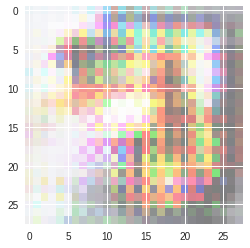

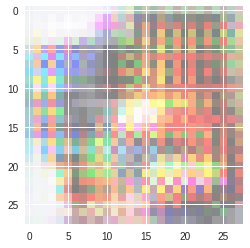

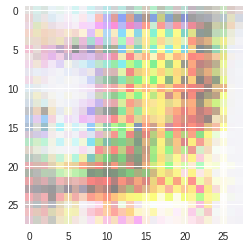

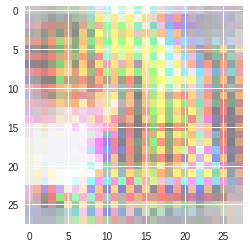

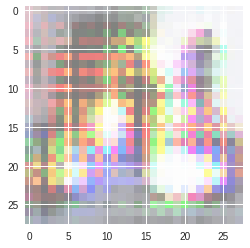

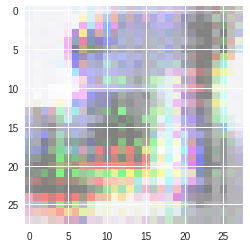

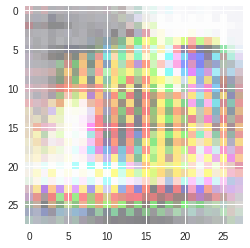

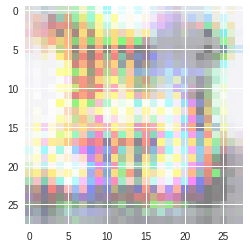

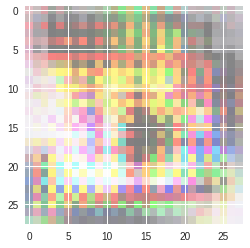

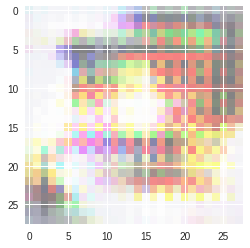

Epoch [48/50], Step [1/10], d_loss: 0.2161, g_loss: 5.6176, D(x): 0.94, D(G(z)): 0.07
Epoch [48/50], Step [2/10], d_loss: 0.2976, g_loss: 5.6779, D(x): 0.88, D(G(z)): 0.06
Epoch [48/50], Step [3/10], d_loss: 0.3155, g_loss: 5.3898, D(x): 0.87, D(G(z)): 0.06
Epoch [48/50], Step [4/10], d_loss: 0.3304, g_loss: 4.9288, D(x): 0.88, D(G(z)): 0.07
Epoch [48/50], Step [5/10], d_loss: 0.2906, g_loss: 4.5794, D(x): 0.90, D(G(z)): 0.09
Epoch [48/50], Step [6/10], d_loss: 0.3064, g_loss: 4.3905, D(x): 0.92, D(G(z)): 0.11
Epoch [48/50], Step [7/10], d_loss: 0.3114, g_loss: 4.5551, D(x): 0.93, D(G(z)): 0.12
Epoch [48/50], Step [8/10], d_loss: 0.2599, g_loss: 5.0828, D(x): 0.94, D(G(z)): 0.11
Epoch [48/50], Step [9/10], d_loss: 0.2474, g_loss: 5.5107, D(x): 0.92, D(G(z)): 0.08
Epoch [48/50], Step [10/10], d_loss: 0.2303, g_loss: 5.7696, D(x): 0.91, D(G(z)): 0.06


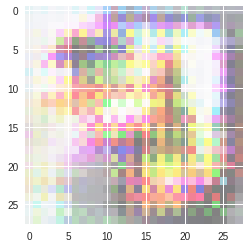

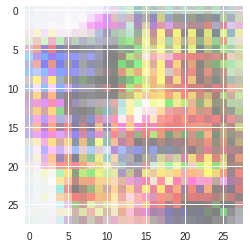

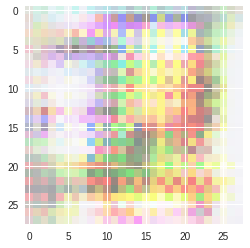

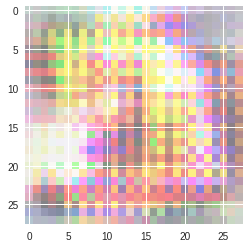

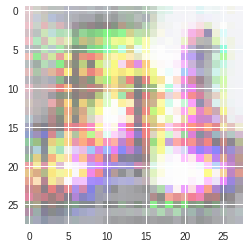

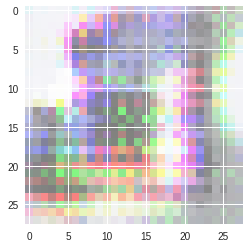

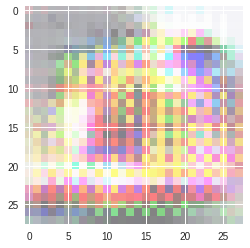

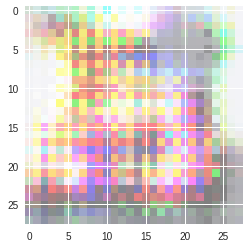

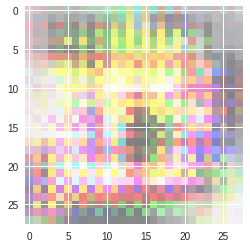

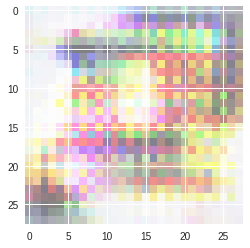

Epoch [49/50], Step [1/10], d_loss: 0.1466, g_loss: 5.9081, D(x): 0.95, D(G(z)): 0.05
Epoch [49/50], Step [2/10], d_loss: 0.2121, g_loss: 5.8274, D(x): 0.91, D(G(z)): 0.05
Epoch [49/50], Step [3/10], d_loss: 0.2148, g_loss: 5.4704, D(x): 0.91, D(G(z)): 0.05
Epoch [49/50], Step [4/10], d_loss: 0.2381, g_loss: 5.0121, D(x): 0.91, D(G(z)): 0.06
Epoch [49/50], Step [5/10], d_loss: 0.2563, g_loss: 4.6501, D(x): 0.92, D(G(z)): 0.09
Epoch [49/50], Step [6/10], d_loss: 0.2966, g_loss: 4.5866, D(x): 0.93, D(G(z)): 0.11
Epoch [49/50], Step [7/10], d_loss: 0.3078, g_loss: 4.8144, D(x): 0.93, D(G(z)): 0.12
Epoch [49/50], Step [8/10], d_loss: 0.2692, g_loss: 5.2598, D(x): 0.93, D(G(z)): 0.10
Epoch [49/50], Step [9/10], d_loss: 0.2938, g_loss: 5.5421, D(x): 0.89, D(G(z)): 0.08
Epoch [49/50], Step [10/10], d_loss: 0.2784, g_loss: 5.5130, D(x): 0.89, D(G(z)): 0.07


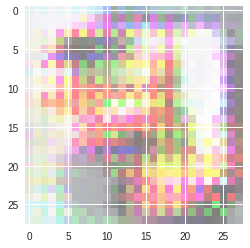

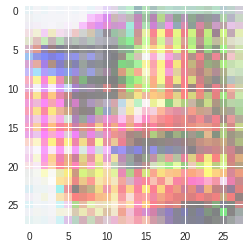

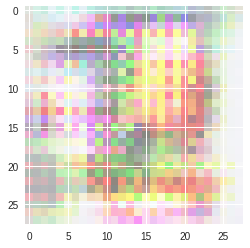

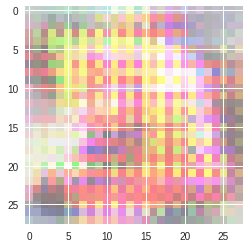

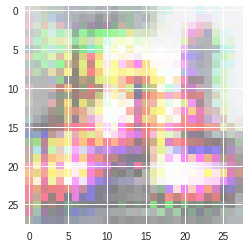

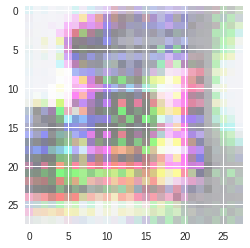

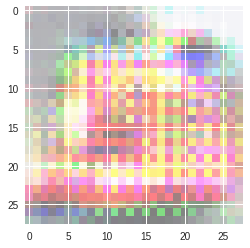

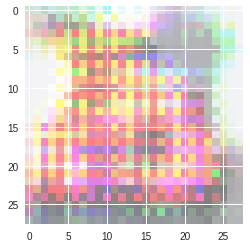

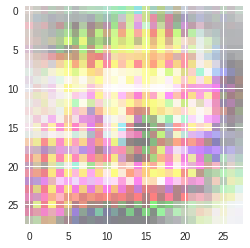

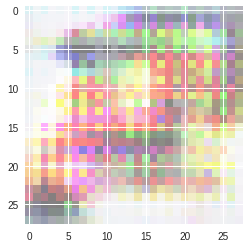

In [97]:
%matplotlib inline
from matplotlib import pyplot as plt


def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

G.apply(weights_init)
D.apply(weights_init)


num_epochs = 50

batch_size = 5000

criterion = nn.BCELoss()

# Create the labels which are later used as input for the BCE loss
real_labels = torch.ones((batch_size, 1, 1, 1), device=device)
fake_labels = torch.zeros((batch_size, 1, 1, 1), device=device)
fixed_noise = torch.randn(batch_size, *latent_shape).to(device)



# Start training
total_step = len(preloaded_data) // batch_size
for epoch in range(num_epochs):
    for i in range(total_step):
        images = preloaded_data[batch_size * i : batch_size * (i+1)]

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #
        D.zero_grad()
        
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs.mean().item()
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        noise = torch.randn(batch_size, *latent_shape).to(device)
        fake_images = G(noise)
        outputs = D(fake_images.detach()) # Don't make a gradient update through G yet
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs.mean().item()
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        del d_loss_real, d_loss_fake
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
        
        # Compute loss with fake images
        G.zero_grad()
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        g_loss.backward()
        g_optimizer.step()
        
        # if (i+1) % 200 == 0:
        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score, fake_score))
        del d_loss, g_loss
    
    # Save the model checkpoints 
    #torch.save(G.state_dict(), 'G.ckpt')
    #torch.save(D.state_dict(), 'D.ckpt')
    
    # Save sampled images
    for image in denorm(G(fixed_noise)).cpu().detach()[:10]:
        plt.figure()
        plt.imshow(tensor2plt(image))
        plt.show()
